In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re

## 1. Data Structure Overview

## 1.1 Load dataset

In [2]:
# Load training dataset and testing dataset
app_train = pd.read_csv('./Dataset/application_train.csv')
app_test = pd.read_csv('./Dataset/application_test.csv')

In [3]:
print(f"Application Train: {app_train.shape}")

Application Train: (307511, 122)


In [4]:
app_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

## 1.2 Types of variables

In [5]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [6]:
numerical_cols = app_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = app_train.select_dtypes(include=["object"]).columns.tolist()

In [7]:
if "TARGET" in numerical_cols:
    numerical_cols.remove("TARGET")
if "SK_ID_CURR" in numerical_cols:
    numerical_cols.remove("SK_ID_CURR")

In [8]:
print("Types of VARIABLEs")
print(f"\nNumerical Variables: {len(numerical_cols)}")
print(f"Categorical Variables: {len(categorical_cols)}")
print(f"Target Variable: 1 (TARGET)")
print(f"Identifier: 1 (SK_ID_CURR)")

print(f"\nNumerical Columns ({len(numerical_cols)}):")
print("-"*80)
for i, col in enumerate(numerical_cols, 1):
    print(f"{i:3d}. {col}")
    
print(f"\nCategorical Columns ({len(categorical_cols)}):")
print("-"*80)
for i, col in enumerate(categorical_cols, 1):
    unique_count = app_train[col].nunique()
    print(f"{i:2d}. {col:40s} - {unique_count} unique values")

Types of VARIABLEs

Numerical Variables: 104
Categorical Variables: 16
Target Variable: 1 (TARGET)
Identifier: 1 (SK_ID_CURR)

Numerical Columns (104):
--------------------------------------------------------------------------------
  1. CNT_CHILDREN
  2. AMT_INCOME_TOTAL
  3. AMT_CREDIT
  4. AMT_ANNUITY
  5. AMT_GOODS_PRICE
  6. REGION_POPULATION_RELATIVE
  7. DAYS_BIRTH
  8. DAYS_EMPLOYED
  9. DAYS_REGISTRATION
 10. DAYS_ID_PUBLISH
 11. OWN_CAR_AGE
 12. FLAG_MOBIL
 13. FLAG_EMP_PHONE
 14. FLAG_WORK_PHONE
 15. FLAG_CONT_MOBILE
 16. FLAG_PHONE
 17. FLAG_EMAIL
 18. CNT_FAM_MEMBERS
 19. REGION_RATING_CLIENT
 20. REGION_RATING_CLIENT_W_CITY
 21. HOUR_APPR_PROCESS_START
 22. REG_REGION_NOT_LIVE_REGION
 23. REG_REGION_NOT_WORK_REGION
 24. LIVE_REGION_NOT_WORK_REGION
 25. REG_CITY_NOT_LIVE_CITY
 26. REG_CITY_NOT_WORK_CITY
 27. LIVE_CITY_NOT_WORK_CITY
 28. EXT_SOURCE_1
 29. EXT_SOURCE_2
 30. EXT_SOURCE_3
 31. APARTMENTS_AVG
 32. BASEMENTAREA_AVG
 33. YEARS_BEGINEXPLUATATION_AVG
 34. YEARS_BUI

# 2. Data Cleaning

## 2.1 Correct Inconsistent values

### 2.1.1 Dirty values -> NaN

In [9]:
SUSPECT_TOKENS = {
    'xna','unknown','na','n/a','none','null','#n/a','#na','?', 'n.a.'
}

In [10]:
def find_suspect_tokens(df, min_count=1):
    hits = {}
    for c in df.select_dtypes(include=['object']).columns:
        s = df[c].dropna().astype(str).str.strip().str.lower()
        vc = s.value_counts()
        bad = vc[vc.index.isin(SUSPECT_TOKENS)]
        if not bad.empty and bad.sum() >= min_count:
            hits[c] = bad.to_dict()
    return hits

In [11]:
suspect_report = find_suspect_tokens(app_train)  
print(suspect_report)

{'CODE_GENDER': {'xna': 4}, 'NAME_FAMILY_STATUS': {'unknown': 2}, 'ORGANIZATION_TYPE': {'xna': 55374}}


In [12]:
def replace_suspects_with_nan(df):
    obj_cols = df.select_dtypes(include=['object']).columns
    pat = re.compile(r'^\s*(?:' + '|'.join(map(re.escape, SUSPECT_TOKENS)) + r')\s*$', flags=re.I)
    for c in obj_cols:
        # Treat '' as missing values
        df[c] = df[c].apply(lambda x: np.nan if isinstance(x, str) and x.strip()=='' else x)
        # Treat suspect token as missing values
        df[c] = df[c].apply(lambda x: np.nan if isinstance(x, str) and pat.match(x) else x)
    return df

In [13]:
app_train = replace_suspects_with_nan(app_train)
app_test  = replace_suspects_with_nan(app_test)

### 2.1.2 DAYS_* Anomaly

In [14]:
def audit_days_columns(df):
    days_cols = [c for c in df.columns if c.startswith('DAYS_')]
    rows = []
    for c in days_cols:
        s = df[c]
        n = len(s)
        rows.append({
            'col': c,
            'n': n,
            'missing_rate': s.isna().mean(),
            'pos_count': int((s > 0).sum()),
            'pos_rate': float((s > 0).mean()),
            'eq_365243': int((s == 365243).sum()),
            'min': s.min(skipna=True),
            'p1': s.quantile(0.01),
            'q1': s.quantile(0.25),
            'median': s.quantile(0.50),
            'q3': s.quantile(0.75),
            'p99': s.quantile(0.99),
            'max': s.max(skipna=True)
        })
    report = pd.DataFrame(rows).sort_values(['pos_rate','eq_365243'], ascending=False)

    spikes = {}
    for c in days_cols:
        s = df[c].dropna()
        if len(s) == 0: 
            continue
        vc = s.value_counts()
        top = (vc.head(3) / len(s)).round(4)
        spikes[c] = top.to_dict()

    # Check logical consistency
    cross = {}
    def has(*cols): return set(cols).issubset(df.columns)
    if has('DAYS_BIRTH','DAYS_REGISTRATION'):
        cross['reg_before_birth'] = int((df['DAYS_REGISTRATION'].abs() > df['DAYS_BIRTH'].abs()).sum())
    if has('DAYS_BIRTH','DAYS_ID_PUBLISH'):
        cross['id_issued_before_birth'] = int((df['DAYS_ID_PUBLISH'].abs() > df['DAYS_BIRTH'].abs()).sum())
    if has('DAYS_BIRTH','DAYS_LAST_PHONE_CHANGE'):
        cross['phone_change_before_birth'] = int((df['DAYS_LAST_PHONE_CHANGE'].abs() > df['DAYS_BIRTH'].abs()).sum())
    if has('DAYS_BIRTH','DAYS_EMPLOYED'):
        cross['employed_longer_than_age_minus14y'] = int(
            (df['DAYS_EMPLOYED'].abs() > (df['DAYS_BIRTH'].abs() - 14*365)).sum()
        )

    # Check age boundry
    age_flags = {}
    if 'DAYS_BIRTH' in df.columns:
        age = (-df['DAYS_BIRTH']) / 365.0
        age_flags['age_lt_18']  = int((age < 18).sum())
        age_flags['age_gt_100'] = int((age > 100).sum())

    return report, spikes, cross, age_flags

In [15]:
report, spikes, cross, age_flags = audit_days_columns(app_train)
display(report) 
print()
print(spikes)
print()
print(cross) 
print()
print(age_flags)

col       n  missing_rate  pos_count  pos_rate  \
1           DAYS_EMPLOYED  307511      0.000000      55374  0.180072   
0              DAYS_BIRTH  307511      0.000000          0  0.000000   
2       DAYS_REGISTRATION  307511      0.000000          0  0.000000   
3         DAYS_ID_PUBLISH  307511      0.000000          0  0.000000   
4  DAYS_LAST_PHONE_CHANGE  307511      0.000003          0  0.000000   

   eq_365243      min       p1       q1   median       q3       p99       max  
1      55374 -17912.0 -10894.9  -2760.0  -1213.0   -289.0  365243.0  365243.0  
0          0 -25229.0 -24419.0 -19682.0 -15750.0 -12413.0   -8263.0   -7489.0  
2          0 -24672.0 -13879.0  -7479.5  -4504.0  -2010.0     -50.0       0.0  
3          0  -7197.0  -5447.0  -4299.0  -3254.0  -1720.0     -61.0       0.0  
4          0  -4292.0  -3149.0  -1570.0   -757.0   -274.0       0.0       0.0


{'DAYS_BIRTH': {-13749: 0.0001, -13481: 0.0001, -18248: 0.0001}, 'DAYS_EMPLOYED': {365243: 0.1801, -200: 0.0005, -224: 0.0005}, 'DAYS_REGISTRATION': {-1.0: 0.0004, -7.0: 0.0003, -6.0: 0.0003}, 'DAYS_ID_PUBLISH': {-4053: 0.0005, -4095: 0.0005, -4046: 0.0005}, 'DAYS_LAST_PHONE_CHANGE': {0.0: 0.1225, -1.0: 0.0091, -2.0: 0.0075}}

{'reg_before_birth': 1, 'id_issued_before_birth': 0, 'phone_change_before_birth': 0, 'employed_longer_than_age_minus14y': 55374}

{'age_lt_18': 0, 'age_gt_100': 0}


In [16]:
def mark_days_anomalies(df, *, floor=None, add_age_flags=True):
    
    day_cols = [c for c in df.columns if c.startswith('DAYS_')]
    for c in day_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    for c in day_cols:
        if c == 'DAYS_EMPLOYED':
            df['EMPLOYMENT_ANOMALY'] = (df[c] == 365243).astype('Int8')
            df.loc[df[c] == 365243, c] = pd.NA

        anom_col = f'{c}_ANOMALY'
        df[anom_col] = (df[c] > 0).fillna(False).astype('Int8')
        df.loc[df[c] > 0, c] = np.nan

    return df

app_train = mark_days_anomalies(app_train, floor=None, add_age_flags=True)
app_test  = mark_days_anomalies(app_test,  floor=None, add_age_flags=True)

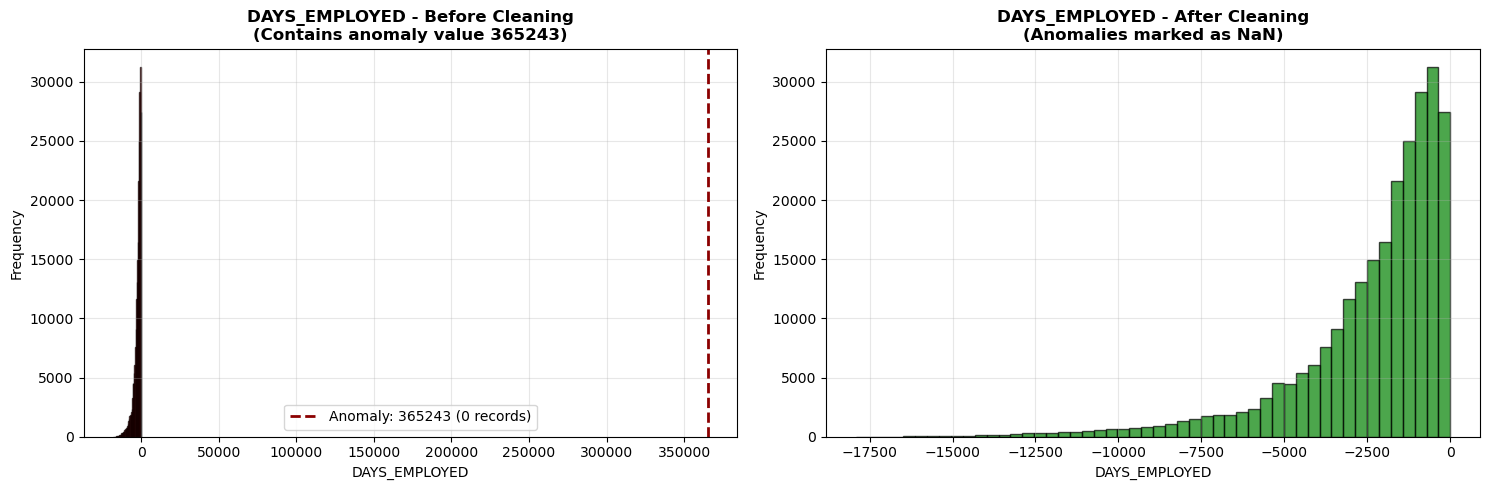

Before cleaning: 252137 non-null values, 0 anomalies
After cleaning: 252137 non-null values
Anomalies converted to NaN: 0


In [17]:
# Visualization: DAYS_EMPLOYED Anomaly Handling (Before/After)
# Create a copy before cleaning for comparison
app_train_before_days = app_train.copy()

# Apply the cleaning
app_train = mark_days_anomalies(app_train)
app_test = mark_days_anomalies(app_test)

# Visualize before/after
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Before cleaning
ax1 = axes[0]
before_data = app_train_before_days['DAYS_EMPLOYED'].dropna()
ax1.hist(before_data, bins=50, edgecolor='black', alpha=0.7, color='red')
ax1.set_title('DAYS_EMPLOYED - Before Cleaning\n(Contains anomaly value 365243)', fontsize=12, fontweight='bold')
ax1.set_xlabel('DAYS_EMPLOYED')
ax1.set_ylabel('Frequency')
anomaly_count = (before_data == 365243).sum()
ax1.axvline(x=365243, color='darkred', linestyle='--', linewidth=2, label=f'Anomaly: 365243 ({anomaly_count} records)')
ax1.legend()
ax1.grid(alpha=0.3)

# After cleaning
ax2 = axes[1]
after_data = app_train['DAYS_EMPLOYED'].dropna()
ax2.hist(after_data, bins=50, edgecolor='black', alpha=0.7, color='green')
ax2.set_title('DAYS_EMPLOYED - After Cleaning\n(Anomalies marked as NaN)', fontsize=12, fontweight='bold')
ax2.set_xlabel('DAYS_EMPLOYED')
ax2.set_ylabel('Frequency')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Before cleaning: {len(before_data)} non-null values, {anomaly_count} anomalies")
print(f"After cleaning: {len(after_data)} non-null values")
print(f"Anomalies converted to NaN: {len(before_data) - len(after_data)}")

## 2.2 Missing Value

### 2.2.1 Detecting Missing Values

MISSING VALUES STATUS - BEFORE CLEANING

Total missing values: 9,263,219
Overall missing rate: 22.65%

Top 20 columns with missing values:
                                            column  missing_count  missing_pct
COMMONAREA_MEDI                    COMMONAREA_MEDI         214865    69.872297
COMMONAREA_AVG                      COMMONAREA_AVG         214865    69.872297
COMMONAREA_MODE                    COMMONAREA_MODE         214865    69.872297
NONLIVINGAPARTMENTS_MODE  NONLIVINGAPARTMENTS_MODE         213514    69.432963
NONLIVINGAPARTMENTS_MEDI  NONLIVINGAPARTMENTS_MEDI         213514    69.432963
NONLIVINGAPARTMENTS_AVG    NONLIVINGAPARTMENTS_AVG         213514    69.432963
FONDKAPREMONT_MODE              FONDKAPREMONT_MODE         210295    68.386172
LIVINGAPARTMENTS_MODE        LIVINGAPARTMENTS_MODE         210199    68.354953
LIVINGAPARTMENTS_MEDI        LIVINGAPARTMENTS_MEDI         210199    68.354953
LIVINGAPARTMENTS_AVG          LIVINGAPARTMENTS_AVG         210199    68

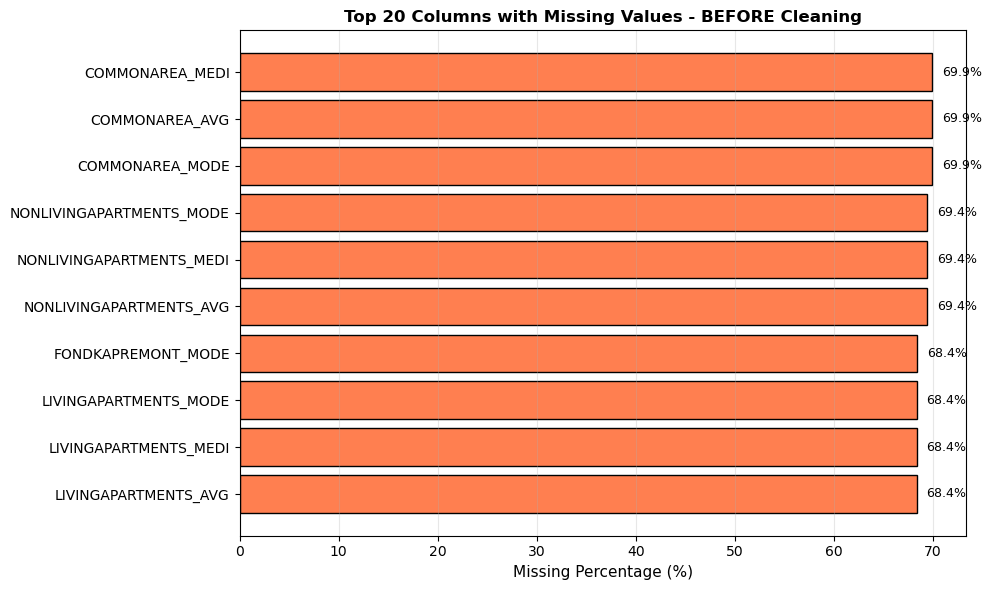

In [18]:
# Save missing values status BEFORE cleaning for later comparison
def get_top_missing(df, top_n=20):
    missing_df = pd.DataFrame({
        'column': df.columns,
        'missing_count': df.isnull().sum(),
        'missing_pct': (df.isnull().sum() / len(df)) * 100
    })
    missing_df = missing_df[missing_df['missing_count'] > 0].sort_values('missing_pct', ascending=False)
    return missing_df.head(top_n)

# Store missing stats BEFORE cleaning
missing_before = get_top_missing(app_train, top_n=15)
total_missing_before = app_train.isnull().sum().sum()
overall_missing_rate_before = (total_missing_before / app_train.size) * 100

print("=" * 70)
print("MISSING VALUES STATUS - BEFORE CLEANING")
print("=" * 70)
print(f"\nTotal missing values: {total_missing_before:,}")
print(f"Overall missing rate: {overall_missing_rate_before:.2f}%")
print(f"\nTop 20 columns with missing values:")
print(missing_before.to_string())

# Visualize
plt.figure(figsize=(10, 6))
missing_plot = missing_before.head(10)
plt.barh(missing_plot['column'], missing_plot['missing_pct'], color='coral', edgecolor='black')
plt.xlabel('Missing Percentage (%)', fontsize=11)
plt.title('Top 20 Columns with Missing Values - BEFORE Cleaning', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, (idx, row) in enumerate(missing_plot.iterrows()):
    plt.text(row['missing_pct'] + 1, i, f"{row['missing_pct']:.1f}%", 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [19]:
def analyze_missing_values(df):
    # Calculate missing statistics
    missing_df = pd.DataFrame({
        "column" : df.columns,
        "missing_count": df.isnull().sum(),
        "missing_pct": (df.isnull().sum() / len(df)) * 100,
        "dtype": df.dtypes,
        "nunique": df.nunique()
    })

    missing_df = missing_df[missing_df["missing_count"] > 0].sort_values("missing_pct", ascending=False)

    # Categorize missing levels
    missing_df["missing_category"] = pd.cut(
        missing_df["missing_pct"],
        bins = [0, 10, 30, 70, 100],
        labels = ["Low (<10%)", "Moderate (10-30%)", "High (30-70%)", "Very High (>70%)"]
    )
    return missing_df

missing_analysis = analyze_missing_values(app_train)

In [20]:
print("="*80)
print("MISSING DATA ANALYSIS")
print("="*80)
print(f"\nColumns with missing data: {len(missing_analysis)} / {len(app_train.columns)}")
print(f"\nMissing Data Categories:")
print(missing_analysis['missing_category'].value_counts().sort_index())
print("\n" + "-"*80)
print("\nTop 20 columns with highest missing percentages:")
print(missing_analysis.head(20))

MISSING DATA ANALYSIS

Columns with missing data: 71 / 133

Missing Data Categories:
missing_category
Low (<10%)           12
Moderate (10-30%)     9
High (30-70%)        50
Very High (>70%)      0
Name: count, dtype: int64

--------------------------------------------------------------------------------

Top 20 columns with highest missing percentages:
                                            column  missing_count  \
COMMONAREA_MEDI                    COMMONAREA_MEDI         214865   
COMMONAREA_AVG                      COMMONAREA_AVG         214865   
COMMONAREA_MODE                    COMMONAREA_MODE         214865   
NONLIVINGAPARTMENTS_MODE  NONLIVINGAPARTMENTS_MODE         213514   
NONLIVINGAPARTMENTS_MEDI  NONLIVINGAPARTMENTS_MEDI         213514   
NONLIVINGAPARTMENTS_AVG    NONLIVINGAPARTMENTS_AVG         213514   
FONDKAPREMONT_MODE              FONDKAPREMONT_MODE         210295   
LIVINGAPARTMENTS_MODE        LIVINGAPARTMENTS_MODE         210199   
LIVINGAPARTMENTS_MEDI  

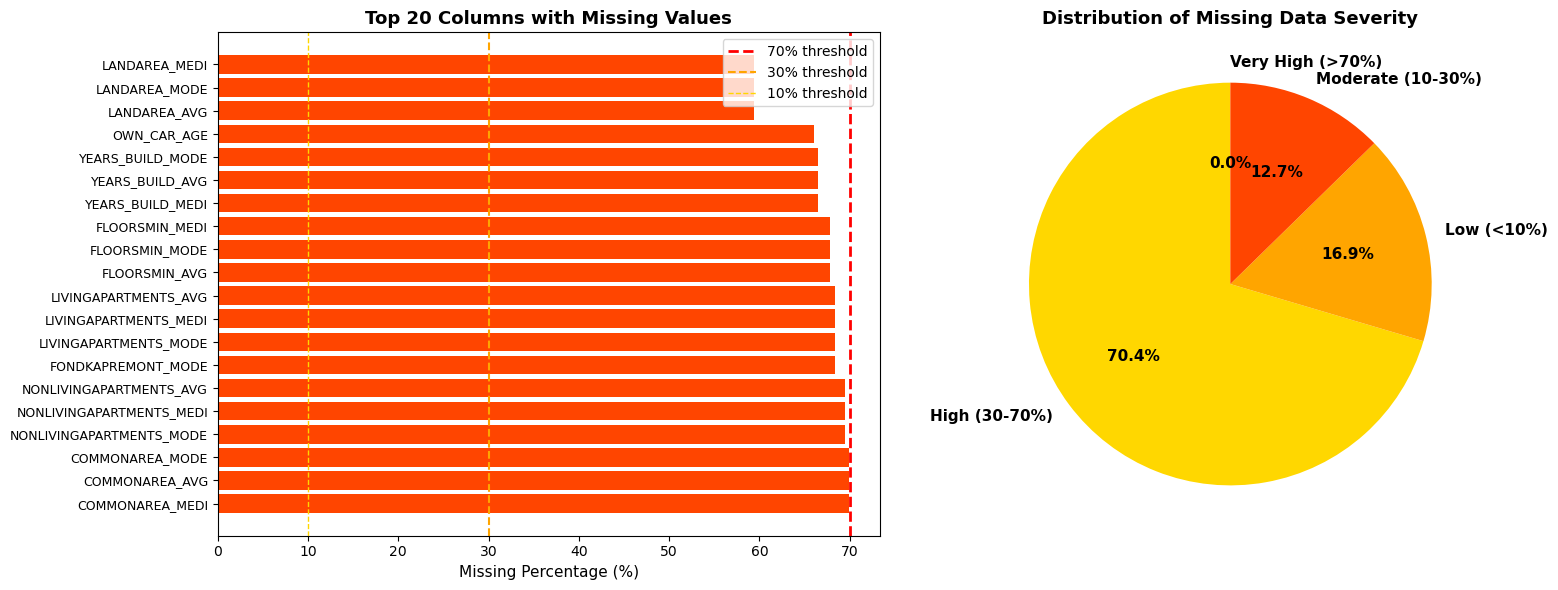

In [21]:
# Visualize missing patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Bar plot of top missing columns
top_20 = missing_analysis.head(20)
colors = top_20['missing_pct'].apply(
    lambda x: 'darkred' if x > 70 else ('orangered' if x > 30 else ('orange' if x > 10 else 'gold'))
)
axes[0].barh(range(len(top_20)), top_20['missing_pct'], color=colors)
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20['column'], fontsize=9)
axes[0].set_xlabel('Missing Percentage (%)', fontsize=11)
axes[0].set_title('Top 20 Columns with Missing Values', fontsize=13, fontweight='bold')
axes[0].axvline(x=70, color='red', linestyle='--', linewidth=2, label='70% threshold')
axes[0].axvline(x=30, color='orange', linestyle='--', linewidth=1.5, label='30% threshold')
axes[0].axvline(x=10, color='gold', linestyle='--', linewidth=1, label='10% threshold')
axes[0].legend()

# 2. Pie chart of missing categories
category_counts = missing_analysis['missing_category'].value_counts()
colors_pie = ['gold', 'orange', 'orangered', 'darkred']
axes[1].pie(category_counts, labels=category_counts.index, autopct='%1.1f%%',
           colors=colors_pie, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Distribution of Missing Data Severity', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

In [22]:
# Check missing correlation with target
def check_missing_correlation_with_target(df, target_col = "TARGET"):
    results = []
    
    for col in df.columns:
        if col == target_col or df[col].isnull().sum() == 0:
            continue
            
        # Create missingness indicator
        is_missing = df[col].isnull().astype(int)
        
        # Calculate default rate when missing vs not missing
        default_rate_missing = df[is_missing == 1][target_col].mean()
        default_rate_not_missing = df[is_missing == 0][target_col].mean()
        
        # Calculate difference
        difference = abs(default_rate_missing - default_rate_not_missing)
        
        results.append({
            'column': col,
            'default_rate_missing': default_rate_missing,
            'default_rate_not_missing': default_rate_not_missing,
            'difference': difference,
            'missing_pct': (df[col].isnull().sum() / len(df)) * 100
        })
    
    results_df = pd.DataFrame(results).sort_values('difference', ascending=False)
    return results_df

# Analyze correlation
missing_target_corr = check_missing_correlation_with_target(app_train)

print("\nTop 10 features where missingness is most predictive of default:")
print(missing_target_corr.head(10))
print("If difference is large (>0.05), missing indicator features should be created.")


Top 10 features where missingness is most predictive of default:
                      column  default_rate_missing  default_rate_not_missing  \
1                AMT_ANNUITY              0.000000                  0.080732   
0                CODE_GENDER              0.000000                  0.080730   
4         NAME_FAMILY_STATUS              0.000000                  0.080729   
8            CNT_FAM_MEMBERS              0.000000                  0.080729   
64    DAYS_LAST_PHONE_CHANGE              0.000000                  0.080729   
63  DEF_60_CNT_SOCIAL_CIRCLE              0.035260                  0.080880   
62  OBS_60_CNT_SOCIAL_CIRCLE              0.035260                  0.080880   
61  DEF_30_CNT_SOCIAL_CIRCLE              0.035260                  0.080880   
60  OBS_30_CNT_SOCIAL_CIRCLE              0.035260                  0.080880   
5              DAYS_EMPLOYED              0.053996                  0.086600   

    difference  missing_pct  
1     0.080732     0.00

### 2.2.2 Handle missing values
- 70 missing: Drop (keep critical features)
- < 70% missing: keep and impute

In [23]:
# Threshold-based feature removal
def drop_high_missing_columns(df_train, df_test, threshold=70, critical_features=None):
    if critical_features is None:
        critical_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
    
    missing_pct = (df_train.isnull().sum() / len(df_train)) * 100
    cols_to_drop = missing_pct[missing_pct > threshold].index.tolist()
 
    cols_to_drop = [col for col in cols_to_drop 
                   if col not in critical_features + ['TARGET', 'SK_ID_CURR']]
    
    if len(cols_to_drop) == 0:
        print(f"No columns with >{threshold}% missing values found")
        return df_train, df_test, []
    
    df_train_new = df_train.drop(columns=cols_to_drop)
    df_test_new = df_test.drop(columns=cols_to_drop)
    
    print(f"Dropped {len(cols_to_drop)} columns with >{threshold}% missing")
    print(f"Train shape: {df_train.shape} → {df_train_new.shape}")
    print(f"Test shape: {df_test.shape} → {df_test_new.shape}")
    
    return df_train_new, df_test_new, cols_to_drop

app_train, app_test, cols_to_drop = drop_high_missing_columns(app_train, app_test)

No columns with >70% missing values found


In [24]:
def create_missing_indicators(df_train, df_test, threshold_difference=0.05):
    missing_corr = check_missing_correlation_with_target(df_train)
    important_missing = missing_corr[
        missing_corr["difference"] > threshold_difference
    ]["column"].tolist()
    
    df_train_new = df_train.copy()
    df_test_new = df_test.copy()
    
    indicator_cols = []
    for col in important_missing:
        if col in df_train_new.columns:
            indicator_name = f"{col}_MISSING"
            df_train_new[indicator_name] = df_train[col].isnull().astype(int)
            df_test_new[indicator_name] = df_test[col].isnull().astype(int)
            indicator_cols.append(indicator_name)
            
            missing_rate = df_train_new[indicator_name].mean() * 100
            print(f"  {indicator_name:50s}: {missing_rate:6.2f}% missing")
    
    print(f"\nCreated {len(indicator_cols)} missing indicator features")
    return df_train_new, df_test_new, indicator_cols

app_train, app_test, indicator_cols = create_missing_indicators(app_train, app_test)

  AMT_ANNUITY_MISSING                               :   0.00% missing
  CODE_GENDER_MISSING                               :   0.00% missing
  NAME_FAMILY_STATUS_MISSING                        :   0.00% missing
  CNT_FAM_MEMBERS_MISSING                           :   0.00% missing
  DAYS_LAST_PHONE_CHANGE_MISSING                    :   0.00% missing

Created 5 missing indicator features


In [25]:
def compute_fill_values(df):
    fill_values = {}
    protected_cols = ['SK_ID_CURR', 'TARGET']
    
    for col in df.columns:
        if col in protected_cols or df[col].isnull().sum() == 0:
            continue
        
        # Object: use mode
        if df[col].dtype == 'object':
            mode_val = df[col].mode()
            fill_values[col] = mode_val[0] if len(mode_val) > 0 else 'Unknown'
        
        # Numeric：
        else:
            # Amount: use median
            if 'AMT_' in col:
                fill_values[col] = df[col].median()
            
            # Days: use median
            elif 'DAYS_' in col:
                fill_values[col] = df[col].median()
            
            # Flag: use median
            elif 'FLAG_' in col:
                fill_values[col] = df[col].median()
            
            # Count: use median
            elif 'CNT_' in col:
                fill_values[col] = df[col].median()
            
            # Social circle: use 0
            elif 'SOCIAL_CIRCLE' in col:
                fill_values[col] = 0
            
            # External source: use median
            elif 'EXT_SOURCE' in col:
                fill_values[col] = df[col].median()
            
            # Others: use median
            else:
                fill_values[col] = df[col].median()
    
    return fill_values

fill_values = compute_fill_values(app_train)

In [26]:
fill_values

{'CODE_GENDER': 'F',
 'AMT_ANNUITY': 24903.0,
 'AMT_GOODS_PRICE': 450000.0,
 'NAME_TYPE_SUITE': 'Unaccompanied',
 'NAME_FAMILY_STATUS': 'Married',
 'DAYS_EMPLOYED': -1648.0,
 'OWN_CAR_AGE': 9.0,
 'OCCUPATION_TYPE': 'Laborers',
 'CNT_FAM_MEMBERS': 2.0,
 'ORGANIZATION_TYPE': 'Business Entity Type 3',
 'EXT_SOURCE_1': 0.5059979305057544,
 'EXT_SOURCE_2': 0.5659614260608526,
 'EXT_SOURCE_3': 0.5352762504724826,
 'APARTMENTS_AVG': 0.0876,
 'BASEMENTAREA_AVG': 0.0763,
 'YEARS_BEGINEXPLUATATION_AVG': 0.9816,
 'YEARS_BUILD_AVG': 0.7552,
 'COMMONAREA_AVG': 0.0211,
 'ELEVATORS_AVG': 0.0,
 'ENTRANCES_AVG': 0.1379,
 'FLOORSMAX_AVG': 0.1667,
 'FLOORSMIN_AVG': 0.2083,
 'LANDAREA_AVG': 0.0481,
 'LIVINGAPARTMENTS_AVG': 0.0756,
 'LIVINGAREA_AVG': 0.0745,
 'NONLIVINGAPARTMENTS_AVG': 0.0,
 'NONLIVINGAREA_AVG': 0.0036,
 'APARTMENTS_MODE': 0.084,
 'BASEMENTAREA_MODE': 0.0746,
 'YEARS_BEGINEXPLUATATION_MODE': 0.9816,
 'YEARS_BUILD_MODE': 0.7648,
 'COMMONAREA_MODE': 0.019,
 'ELEVATORS_MODE': 0.0,
 'ENTRANCES

In [27]:
def apply_fill_values(df_train, df_test, fill_values):
    
    df_train_filled = df_train.fillna(fill_values)
    df_test_filled = df_test.fillna(fill_values)
    
    print(f"Applied fill values to {len(fill_values)} columns")
    print(f"Train missing values after filling: {df_train_filled.isnull().sum().sum()}")
    print(f"Test missing values after filling: {df_test_filled.isnull().sum().sum()}")
    
    return df_train_filled, df_test_filled

app_train, app_test = apply_fill_values(app_train, app_test, fill_values)

Applied fill values to 71 columns
Train missing values after filling: 0
Test missing values after filling: 0


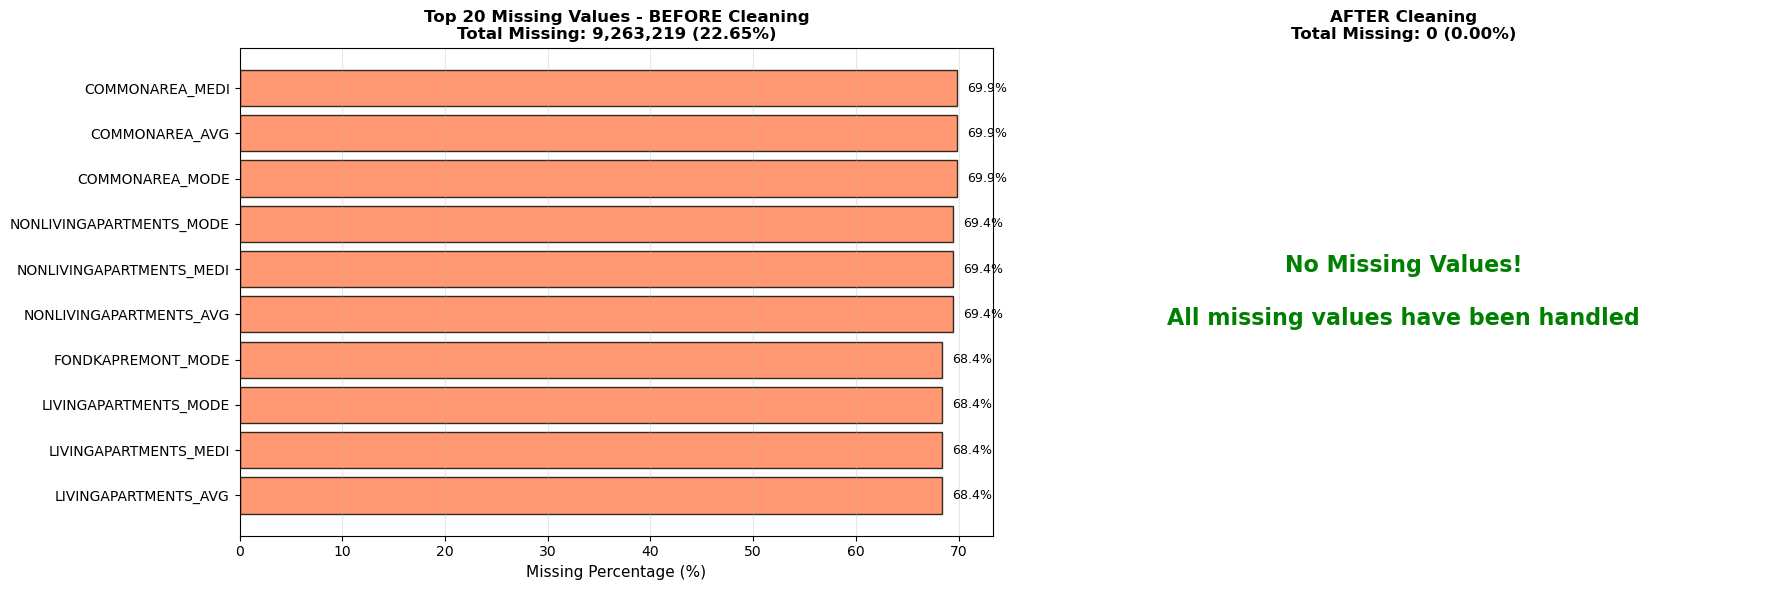

In [28]:
# Get missing stats AFTER all cleaning operations
missing_after = get_top_missing(app_train, top_n=20)
total_missing_after = app_train.isnull().sum().sum()
overall_missing_rate_after = (total_missing_after / app_train.size) * 100

# Side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Before cleaning
ax1 = axes[0]
missing_before_plot = missing_before.head(10)
bars1 = ax1.barh(missing_before_plot['column'], missing_before_plot['missing_pct'], 
                 color='coral', edgecolor='black', alpha=0.8)
ax1.set_xlabel('Missing Percentage (%)', fontsize=11)
ax1.set_title(f'Top 20 Missing Values - BEFORE Cleaning\nTotal Missing: {total_missing_before:,} ({overall_missing_rate_before:.2f}%)', 
              fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, (idx, row) in enumerate(missing_before_plot.iterrows()):
    ax1.text(row['missing_pct'] + 1, i, f"{row['missing_pct']:.1f}%", 
             va='center', fontsize=9)

# After cleaning
ax2 = axes[1]
if len(missing_after) > 0:
    missing_after_plot = missing_after.head(10)
    bars2 = ax2.barh(missing_after_plot['column'], missing_after_plot['missing_pct'], 
                     color='lightgreen', edgecolor='black', alpha=0.8)
    ax2.set_xlabel('Missing Percentage (%)', fontsize=11)
    ax2.set_title(f'Top 20 Missing Values - AFTER Cleaning\nTotal Missing: {total_missing_after:,} ({overall_missing_rate_after:.2f}%)', 
                  fontsize=12, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(axis='x', alpha=0.3)
    
    # Add percentage labels
    for i, (idx, row) in enumerate(missing_after_plot.iterrows()):
        ax2.text(row['missing_pct'] + 1, i, f"{row['missing_pct']:.1f}%", 
                 va='center', fontsize=9)
else:
    ax2.text(0.5, 0.5, 'No Missing Values!\n\nAll missing values have been handled', 
             ha='center', va='center', fontsize=16, fontweight='bold', color='green',
             transform=ax2.transAxes)
    ax2.set_title(f'AFTER Cleaning\nTotal Missing: {total_missing_after:,} ({overall_missing_rate_after:.2f}%)', 
                  fontsize=12, fontweight='bold')
    ax2.axis('off')

plt.tight_layout()
plt.show()

## 2.3 Checking Duplicates

In [29]:
app_train.duplicated().sum()

0

In [30]:
app_test.duplicated().sum()

0

# 3. Descriptive Statistics

In [31]:
def descriptive_statistics(df):
    
    print("="*80)
    print("DESCRIPTIVE STATISTICS SUMMARY")
    print("="*80)
    
    # Basic info
    print(f"\nShape: {df.shape}")
    print(f"Dtypes:\n{df.dtypes.value_counts()}")
    
    # Statistics
    print("\n" + "="*80)
    print("NUMERICAL FEATURES")
    print("="*80)
    num_stats = df.describe(include=[np.number]).T
    num_stats['skewness'] = df.select_dtypes(include=[np.number]).skew()
    num_stats['kurtosis'] = df.select_dtypes(include=[np.number]).kurtosis()
    
    print(num_stats.round(4))
    
    print("\n" + "="*80)
    print("CATEGORICAL FEATURES")
    print("="*80)
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    if cat_cols:
        cat_stats = pd.DataFrame({
            'column': cat_cols,
            'unique': [df[col].nunique() for col in cat_cols],
            'mode': [df[col].mode()[0] if len(df[col].mode()) > 0 else 'N/A' for col in cat_cols]
        })
        print(cat_stats.to_string(index=False))
    else:
        print("No categorical features")
        cat_stats = None
    
    return num_stats, cat_stats

num_stats, cat_stats = descriptive_statistics(app_train)

DESCRIPTIVE STATISTICS SUMMARY

Shape: (307511, 138)
Dtypes:
float64    68
int64      43
object     16
Int8       11
Name: count, dtype: int64

NUMERICAL FEATURES
                                   count           mean            std  \
SK_ID_CURR                      307511.0  278180.518577  102790.175348   
TARGET                          307511.0       0.080729       0.272419   
CNT_CHILDREN                    307511.0       0.417052       0.722121   
AMT_INCOME_TOTAL                307511.0  168797.919297  237123.146279   
AMT_CREDIT                      307511.0  599025.999706  402490.776996   
...                                  ...            ...            ...   
AMT_ANNUITY_MISSING             307511.0       0.000039       0.006247   
CODE_GENDER_MISSING             307511.0       0.000013       0.003607   
NAME_FAMILY_STATUS_MISSING      307511.0       0.000007        0.00255   
CNT_FAM_MEMBERS_MISSING         307511.0       0.000007        0.00255   
DAYS_LAST_PHONE_CHANGE_

# 4. Aggregating Related Tables

## 4.1 Bureau Table

In [32]:
bureau = pd.read_csv('./Dataset/bureau.csv')
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [33]:
bureau.shape

(1716428, 17)

In [34]:
# Check missing values
bureau_missing = bureau.isnull().sum().sort_values(ascending=False)
bureau_missing

AMT_ANNUITY               1226791
AMT_CREDIT_MAX_OVERDUE    1124488
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_DEBT        257669
DAYS_CREDIT_ENDDATE        105553
AMT_CREDIT_SUM                 13
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
SK_ID_BUREAU                    0
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
SK_ID_CURR                      0
dtype: int64

In [35]:
def handle_bureau_missing(bureau):
    
    bureau = bureau.copy()
    
    numeric_cols = bureau.select_dtypes(include=[np.number]).columns
    
    fill_values = {}
    for col in numeric_cols:
        if bureau[col].isnull().sum() > 0:
            if 'AMT_' in col:
                fill_values[col] = 0
            elif 'DAYS_' in col:
                fill_values[col] = bureau[col].median()
            elif 'CNT_' in col:
                fill_values[col] = 0
            else:
                fill_values[col] = bureau[col].median()
    
    categorical_cols = bureau.select_dtypes(include=['object']).columns
    
    for col in categorical_cols:
        if bureau[col].isnull().sum() > 0:
            mode_val = bureau[col].mode()
            fill_values[col] = mode_val[0] if len(mode_val) > 0 else 'Unknown'
    
    bureau = bureau.fillna(fill_values)
    
    print(f"Filled {len(fill_values)} columns")
    print(f"Remaining missing: {bureau.isnull().sum().sum()}")
    
    return bureau

bureau = handle_bureau_missing(bureau)

Filled 7 columns
Remaining missing: 0


In [36]:
bureau.isnull().sum().sum()

0

In [37]:
# Aggregate
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
        'SK_ID_BUREAU': 'count',  
        'DAYS_CREDIT': 'mean',  
        'CREDIT_DAY_OVERDUE': 'max', 
        'AMT_CREDIT_SUM': 'mean',  
        'AMT_CREDIT_SUM_DEBT': 'mean'  
    }).reset_index()

In [38]:
bureau_agg.columns = ['SK_ID_CURR', 'BUREAU_LOAN_COUNT', 'BUREAU_DAYS_CREDIT_MEAN',
                         'BUREAU_MAX_OVERDUE', 'BUREAU_CREDIT_MEAN', 'BUREAU_DEBT_MEAN']

In [39]:
app_train = app_train.merge(bureau_agg, on='SK_ID_CURR', how='left')
app_test = app_test.merge(bureau_agg, on='SK_ID_CURR', how='left')

In [40]:
bureau_cols = [col for col in bureau_agg.columns if col != 'SK_ID_CURR']
app_train[bureau_cols] = app_train[bureau_cols].fillna(0)
app_test[bureau_cols] = app_test[bureau_cols].fillna(0)

In [41]:
len(bureau_cols)

5

In [42]:
app_train.isnull().sum()

SK_ID_CURR                 0
TARGET                     0
NAME_CONTRACT_TYPE         0
CODE_GENDER                0
FLAG_OWN_CAR               0
                          ..
BUREAU_LOAN_COUNT          0
BUREAU_DAYS_CREDIT_MEAN    0
BUREAU_MAX_OVERDUE         0
BUREAU_CREDIT_MEAN         0
BUREAU_DEBT_MEAN           0
Length: 143, dtype: int64

In [43]:
app_test.isnull().sum()

SK_ID_CURR                 0
NAME_CONTRACT_TYPE         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
                          ..
BUREAU_LOAN_COUNT          0
BUREAU_DAYS_CREDIT_MEAN    0
BUREAU_MAX_OVERDUE         0
BUREAU_CREDIT_MEAN         0
BUREAU_DEBT_MEAN           0
Length: 142, dtype: int64

In [44]:
app_train.shape

(307511, 143)

In [45]:
app_test.shape

(48744, 142)

## 4.2 Previous Application Table

In [46]:
prev_app = pd.read_csv('./Dataset/previous_application.csv')
prev_app.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

In [47]:
prev_app.shape

(1670214, 37)

In [48]:
# Check missing values
prev_missing = prev_app.isnull().sum().sort_values(ascending=False)
prev_missing

RATE_INTEREST_PRIVILEGED       1664263
RATE_INTEREST_PRIMARY          1664263
AMT_DOWN_PAYMENT                895844
RATE_DOWN_PAYMENT               895844
NAME_TYPE_SUITE                 820405
NFLAG_INSURED_ON_APPROVAL       673065
DAYS_TERMINATION                673065
DAYS_LAST_DUE                   673065
DAYS_LAST_DUE_1ST_VERSION       673065
DAYS_FIRST_DUE                  673065
DAYS_FIRST_DRAWING              673065
AMT_GOODS_PRICE                 385515
AMT_ANNUITY                     372235
CNT_PAYMENT                     372230
PRODUCT_COMBINATION                346
AMT_CREDIT                           1
NAME_YIELD_GROUP                     0
NAME_PORTFOLIO                       0
NAME_SELLER_INDUSTRY                 0
SELLERPLACE_AREA                     0
CHANNEL_TYPE                         0
NAME_PRODUCT_TYPE                    0
SK_ID_PREV                           0
NAME_GOODS_CATEGORY                  0
NAME_CLIENT_TYPE                     0
CODE_REJECT_REASON       

In [49]:
# Handle missing values
def handle_previous_application_missing(prev_app):
    
    prev_app = prev_app.copy()
    
    numeric_cols = prev_app.select_dtypes(include=[np.number]).columns
    
    fill_values = {}
    for col in numeric_cols:
        if prev_app[col].isnull().sum() > 0:
            if 'AMT_' in col:
                fill_values[col] = 0
            elif 'DAYS_' in col:
                fill_values[col] = prev_app[col].median()
            elif 'CNT_' in col:
                fill_values[col] = 0
            elif 'RATE_' in col:
                fill_values[col] = prev_app[col].median()
            elif 'HOUR_' in col:
                fill_values[col] = prev_app[col].median()
            elif 'FLAG' in col or 'NFLAG' in col:
                fill_values[col] = 0
            else:
                fill_values[col] = prev_app[col].median()
    
    categorical_cols = prev_app.select_dtypes(include=['object']).columns
    
    for col in categorical_cols:
        if prev_app[col].isnull().sum() > 0:
            mode_val = prev_app[col].mode()
            fill_values[col] = mode_val[0] if len(mode_val) > 0 else 'Unknown'
    
    prev_app = prev_app.fillna(fill_values)
    
    print(f"Filled {len(fill_values)} columns")
    print(f"Remaining missing: {prev_app.isnull().sum().sum()}")
    
    return prev_app

prev_app = handle_previous_application_missing(prev_app)

Filled 16 columns
Remaining missing: 0


In [50]:
prev_app.isnull().sum().sum()

0

In [51]:
# Aggregate
prev_agg = prev_app.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'count', 
        'AMT_APPLICATION': 'mean',  
        'AMT_CREDIT': 'mean', 
        'DAYS_DECISION': 'mean'  
    }).reset_index()

In [52]:
prev_agg.columns = ['SK_ID_CURR', 'PREV_APP_COUNT', 'PREV_AMT_APPLICATION_MEAN',
                       'PREV_AMT_CREDIT_MEAN', 'PREV_DAYS_DECISION_MEAN']

In [53]:
app_train = app_train.merge(prev_agg, on='SK_ID_CURR', how='left')
app_test = app_test.merge(prev_agg, on='SK_ID_CURR', how='left')

In [54]:
prev_cols = [col for col in prev_agg.columns if col != 'SK_ID_CURR']
app_train[prev_cols] = app_train[prev_cols].fillna(0)
app_test[prev_cols] = app_test[prev_cols].fillna(0)

In [55]:
len(prev_cols)

4

In [56]:
app_train.shape

(307511, 147)

In [57]:
app_test.shape

(48744, 146)

## 4.3 Installments Payments

In [58]:
installments = pd.read_csv('./Dataset/installments_payments.csv')
installments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [59]:
installments.shape

(13605401, 8)

In [60]:
# Check missing values
installments_missing = installments.isnull().sum().sort_values(ascending=False)
installments_missing

DAYS_ENTRY_PAYMENT        2905
AMT_PAYMENT               2905
SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
AMT_INSTALMENT               0
dtype: int64

In [61]:
def handle_installments_missing(installments):
    
    installments = installments.copy()
    
    numeric_cols = installments.select_dtypes(include=[np.number]).columns
    
    fill_values = {}
    for col in numeric_cols:
        if installments[col].isnull().sum() > 0:
            if 'AMT_' in col:
                fill_values[col] = 0
            elif 'DAYS_' in col:
                fill_values[col] = installments[col].median()
            elif 'NUM_' in col:
                fill_values[col] = 0
            else:
                fill_values[col] = installments[col].median()
    
    installments = installments.fillna(fill_values)
    
    if 'AMT_PAYMENT' in installments.columns and 'AMT_INSTALMENT' in installments.columns:
        installments['PAYMENT_RATIO'] = installments['AMT_PAYMENT'] / (installments['AMT_INSTALMENT'] + 0.001)
    
    if 'DAYS_ENTRY_PAYMENT' in installments.columns and 'DAYS_INSTALMENT' in installments.columns:
        installments['PAYMENT_DELAY'] = installments['DAYS_ENTRY_PAYMENT'] - installments['DAYS_INSTALMENT']
    
    print(f"Filled {len(fill_values)} columns")
    print(f"Remaining missing: {installments.isnull().sum().sum()}")
    
    return installments

installments = handle_installments_missing(installments)

Filled 2 columns
Remaining missing: 0


In [62]:
# Aggregate
inst_agg = installments.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'nunique', 
        'NUM_INSTALMENT_NUMBER': 'max',  
        'AMT_INSTALMENT': 'mean', 
        'AMT_PAYMENT': 'mean',  
        'PAYMENT_RATIO': 'mean',  
        'PAYMENT_DELAY': ['mean', 'max']  
    }).reset_index()

In [63]:
inst_agg.columns = ['SK_ID_CURR', 'INST_LOAN_COUNT', 'INST_MAX_INSTALLMENTS',
                       'INST_AMT_MEAN', 'INST_PAYMENT_MEAN', 'INST_PAYMENT_RATIO_MEAN',
                       'INST_DELAY_MEAN', 'INST_DELAY_MAX']

In [64]:
app_train = app_train.merge(inst_agg, on='SK_ID_CURR', how='left')
app_test = app_test.merge(inst_agg, on='SK_ID_CURR', how='left')

In [65]:
inst_cols = [col for col in inst_agg.columns if col != 'SK_ID_CURR']
app_train[inst_cols] = app_train[inst_cols].fillna(0)
app_test[inst_cols] = app_test[inst_cols].fillna(0)

In [66]:
len(inst_cols)

7

In [67]:
app_train.shape

(307511, 154)

In [68]:
app_test.shape

(48744, 153)

## 4.4 POS Cash Balance

In [69]:
pos_cash = pd.read_csv('./Dataset/POS_CASH_balance.csv')
pos_cash.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [70]:
pos_cash.shape

(10001358, 8)

In [71]:
# Check missing values
pos_cash_missing = pos_cash.isnull().sum().sort_values(ascending=False)
pos_cash_missing

CNT_INSTALMENT_FUTURE    26087
CNT_INSTALMENT           26071
SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64

In [72]:
def handle_pos_cash_missing(pos_cash):
    
    pos_cash = pos_cash.copy()
    
    numeric_cols = pos_cash.select_dtypes(include=[np.number]).columns
    
    fill_values = {}
    for col in numeric_cols:
        if pos_cash[col].isnull().sum() > 0:
            if 'CNT_' in col:
                fill_values[col] = 0
            elif 'SK_DPD' in col:
                fill_values[col] = 0
            elif 'MONTHS_BALANCE' in col:
                fill_values[col] = pos_cash[col].median()
            else:
                fill_values[col] = pos_cash[col].median()
    
    categorical_cols = pos_cash.select_dtypes(include=['object']).columns
    
    for col in categorical_cols:
        if pos_cash[col].isnull().sum() > 0:
            mode_val = pos_cash[col].mode()
            fill_values[col] = mode_val[0] if len(mode_val) > 0 else 'Unknown'
    
    pos_cash = pos_cash.fillna(fill_values)
    
    print(f"Filled {len(fill_values)} columns")
    print(f"Remaining missing: {pos_cash.isnull().sum().sum()}")
    
    return pos_cash


pos_cash = handle_pos_cash_missing(pos_cash)

Filled 2 columns
Remaining missing: 0


In [73]:
pos_cash.isnull().sum().sum()

0

In [74]:
# Aggregate
pos_agg = pos_cash.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'nunique',  
        'MONTHS_BALANCE': 'count',  
        'CNT_INSTALMENT': 'mean', 
        'CNT_INSTALMENT_FUTURE': 'mean',  
        'SK_DPD': ['mean', 'max'], 
        'SK_DPD_DEF': ['mean', 'max'] 
    }).reset_index()

In [75]:
pos_agg.columns = ['SK_ID_CURR', 'POS_LOAN_COUNT', 'POS_MONTHS_COUNT',
                  'POS_CNT_INSTALMENT_MEAN', 'POS_CNT_INSTALMENT_FUTURE_MEAN',
                  'POS_DPD_MEAN', 'POS_DPD_MAX', 'POS_DPD_DEF_MEAN', 'POS_DPD_DEF_MAX']

In [76]:
app_train = app_train.merge(pos_agg, on='SK_ID_CURR', how='left')
app_test = app_test.merge(pos_agg, on='SK_ID_CURR', how='left')

In [77]:
pos_cols = [col for col in pos_agg.columns if col != 'SK_ID_CURR']
app_train[pos_cols] = app_train[pos_cols].fillna(0)
app_test[pos_cols] = app_test[pos_cols].fillna(0)

In [78]:
len(pos_cols)

8

In [79]:
app_train.shape

(307511, 162)

In [80]:
app_test.shape

(48744, 161)

## 4.5 Credit Card Balance

In [81]:
credit_card = pd.read_csv('./Dataset/credit_card_balance.csv')
credit_card.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

In [82]:
credit_card.shape

(3840312, 23)

In [83]:
cc_missing = credit_card.isnull().sum().sort_values(ascending=False)
cc_missing

AMT_PAYMENT_CURRENT           767988
AMT_DRAWINGS_ATM_CURRENT      749816
CNT_DRAWINGS_POS_CURRENT      749816
AMT_DRAWINGS_OTHER_CURRENT    749816
AMT_DRAWINGS_POS_CURRENT      749816
CNT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_ATM_CURRENT      749816
CNT_INSTALMENT_MATURE_CUM     305236
AMT_INST_MIN_REGULARITY       305236
SK_ID_PREV                         0
AMT_TOTAL_RECEIVABLE               0
SK_DPD                             0
NAME_CONTRACT_STATUS               0
CNT_DRAWINGS_CURRENT               0
AMT_PAYMENT_TOTAL_CURRENT          0
AMT_RECIVABLE                      0
AMT_RECEIVABLE_PRINCIPAL           0
SK_ID_CURR                         0
AMT_DRAWINGS_CURRENT               0
AMT_CREDIT_LIMIT_ACTUAL            0
AMT_BALANCE                        0
MONTHS_BALANCE                     0
SK_DPD_DEF                         0
dtype: int64

In [84]:
def handle_credit_card_missing(credit_card):
    
    credit_card = credit_card.copy()
    
    numeric_cols = credit_card.select_dtypes(include=[np.number]).columns
    
    fill_values = {}
    for col in numeric_cols:
        if credit_card[col].isnull().sum() > 0:
            if 'AMT_' in col:
                fill_values[col] = 0
            elif 'CNT_' in col:
                fill_values[col] = 0
            elif 'SK_DPD' in col:
                fill_values[col] = 0
            elif 'MONTHS_BALANCE' in col:
                fill_values[col] = credit_card[col].median()
            else:
                fill_values[col] = credit_card[col].median()
    
    categorical_cols = credit_card.select_dtypes(include=['object']).columns
    
    for col in categorical_cols:
        if credit_card[col].isnull().sum() > 0:
            mode_val = credit_card[col].mode()
            fill_values[col] = mode_val[0] if len(mode_val) > 0 else 'Unknown'
    
    credit_card = credit_card.fillna(fill_values)
    
    print(f"Filled {len(fill_values)} columns")
    print(f"Remaining missing: {credit_card.isnull().sum().sum()}")
    
    return credit_card

credit_card = handle_credit_card_missing(credit_card)

Filled 9 columns
Remaining missing: 0


In [85]:
credit_card.isnull().sum().sum()

0

In [86]:
if 'AMT_BALANCE' in credit_card.columns and 'AMT_CREDIT_LIMIT_ACTUAL' in credit_card.columns:
        credit_card['CREDIT_UTILIZATION'] = credit_card['AMT_BALANCE'] / (credit_card['AMT_CREDIT_LIMIT_ACTUAL'] + 0.001)

In [87]:
# Aggregate
cc_agg = credit_card.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'nunique',  
        'MONTHS_BALANCE': 'count',  
        'AMT_BALANCE': 'mean',  
        'AMT_CREDIT_LIMIT_ACTUAL': 'mean',  
        'AMT_DRAWINGS_CURRENT': 'mean',  
        'AMT_PAYMENT_CURRENT': 'mean',  
        'CNT_DRAWINGS_CURRENT': 'sum',  
        'SK_DPD': ['mean', 'max'],  
        'CREDIT_UTILIZATION': 'mean'  
    }).reset_index()

In [88]:
cc_agg.columns = ['SK_ID_CURR', 'CC_COUNT', 'CC_MONTHS_COUNT', 'CC_BALANCE_MEAN',
                     'CC_LIMIT_MEAN', 'CC_DRAWINGS_MEAN', 'CC_PAYMENT_MEAN',
                     'CC_DRAWINGS_TOTAL', 'CC_DPD_MEAN', 'CC_DPD_MAX', 'CC_UTILIZATION_MEAN']

In [89]:
app_train = app_train.merge(cc_agg, on='SK_ID_CURR', how='left')
app_test = app_test.merge(cc_agg, on='SK_ID_CURR', how='left')

In [90]:
cc_cols = [col for col in cc_agg.columns if col != 'SK_ID_CURR']
app_train[cc_cols] = app_train[cc_cols].fillna(0)
app_test[cc_cols] = app_test[cc_cols].fillna(0)

In [91]:
len(cc_cols)

10

In [92]:
app_train.shape

(307511, 172)

In [93]:
app_test.shape

(48744, 171)

## 4.6 Bureau Balance Table

In [94]:
bureau_balance = pd.read_csv('./Dataset/bureau_balance.csv')
bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [95]:
bureau_balance.shape

(27299925, 3)

In [96]:
bureau_balance.isnull().sum().sum()

0

In [97]:
# Aggregate
bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg({
        'MONTHS_BALANCE': 'count',  
        'STATUS': [
            lambda x: (x == 'C').sum(),  
            lambda x: (x == 'X').sum(),  
            lambda x: (x.isin(['1', '2', '3', '4', '5'])).sum()  
        ]
    }).reset_index()

In [98]:
bb_agg.columns = ['SK_ID_BUREAU', 'BB_MONTHS', 'BB_STATUS_CLOSED', 'BB_STATUS_UNKNOWN', 'BB_STATUS_DPD']

In [99]:
bureau_full = bureau.merge(bb_agg, on='SK_ID_BUREAU', how='left')

In [100]:
bb_cols_in_bureau = ['BB_MONTHS', 'BB_STATUS_CLOSED', 'BB_STATUS_UNKNOWN', 'BB_STATUS_DPD']
for col in bb_cols_in_bureau:
    if col in bureau_full.columns:
        bureau_full[col] = bureau_full[col].fillna(0)

In [101]:
bb_client_agg = bureau_full.groupby('SK_ID_CURR').agg({
            'BB_MONTHS': 'sum',
            'BB_STATUS_CLOSED': 'sum',
            'BB_STATUS_DPD': 'sum'
        }).reset_index()

In [102]:
bb_client_agg.columns = ['SK_ID_CURR', 'BUREAU_BALANCE_MONTHS_TOTAL',
                                'BUREAU_BALANCE_CLOSED_TOTAL', 'BUREAU_BALANCE_DPD_TOTAL']

In [103]:
app_train = app_train.merge(bb_client_agg, on='SK_ID_CURR', how='left')
app_test = app_test.merge(bb_client_agg, on='SK_ID_CURR', how='left')

In [104]:
bb_cols = [col for col in bb_client_agg.columns if col != 'SK_ID_CURR']
app_train[bb_cols] = app_train[bb_cols].fillna(0)
app_test[bb_cols] = app_test[bb_cols].fillna(0)

In [105]:
len(bb_cols)

3

In [106]:
app_train.shape

(307511, 175)

In [107]:
app_test.shape

(48744, 174)

# 5. Univariate Analysis (Single Variable)

## 5.1 Target

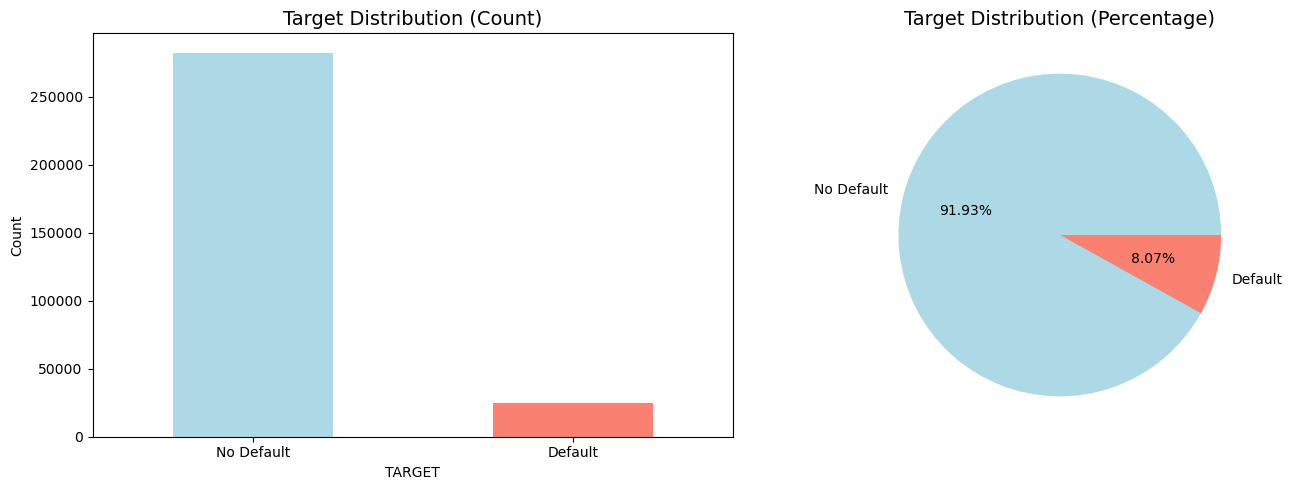

In [108]:
target_counts = app_train['TARGET'].value_counts().sort_index()
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
target_counts.plot(kind='bar', ax=axes[0], color=['lightblue', 'salmon'])
axes[0].set_title('Target Distribution (Count)', fontsize=14)
axes[0].set_xticklabels(['No Default', 'Default'], rotation=0)
axes[0].set_ylabel('Count')

axes[1].pie(target_counts.values, labels=['No Default', 'Default'], 
           autopct='%1.2f%%', colors=['lightblue', 'salmon'])
axes[1].set_title('Target Distribution (Percentage)', fontsize=14)

    
plt.tight_layout()
plt.show()

**Interpretion**

The bar and pie charts above clearly demonstrate a severe class imbalance in the target variable (TARGET):
- Non-default clients account for approximately 91.93% of the dataset. Default clients make up only 8.07%.
- This indicates that the dataset is highly imbalanced, with far fewer default cases compared to non-default ones.
- Such imbalance may cause the model to favor predicting non-defaults, resulting in poor recall for identifying high-risk borrowers.

## 5.2 Numerical Variables

In [109]:
plt.style.use('seaborn-v0_8-whitegrid')

In [110]:
def plot_numerical(df, cols, ncols=3):
    
    nrows = (len(cols) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten()
    
    for i, col in enumerate(cols):
        sns.histplot(data=df, x=col, kde=True, ax=axes[i], bins=30)
        axes[i].set_title(col, fontsize=10)
    
    for j in range(len(cols), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [111]:
def plot_boxplots(df, cols, ncols=4):
   
    nrows = (len(cols) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
    axes = axes.flatten()
    
    for i, col in enumerate(cols):
        sns.boxplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(col, fontsize=10)
    
    for j in range(len(cols), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

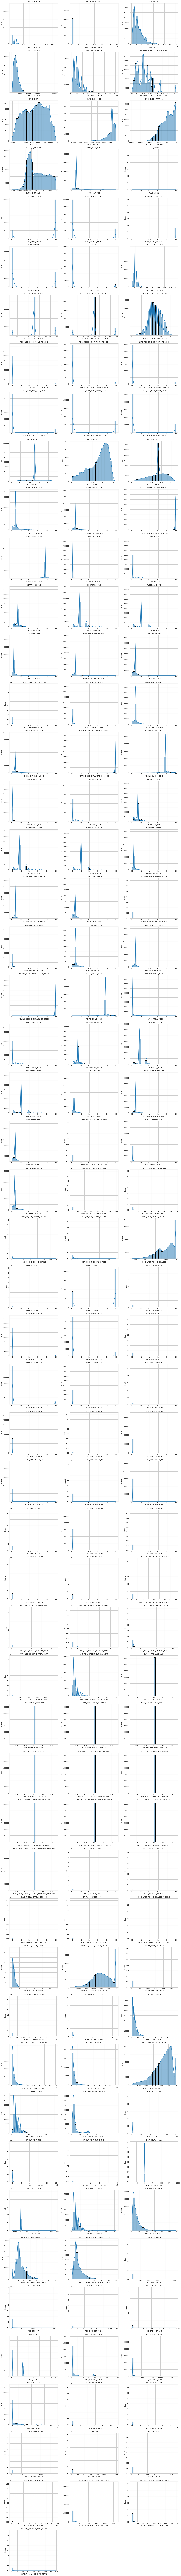

In [112]:
exclude = ['SK_ID_CURR', 'TARGET']
numeric_cols = [col for col in app_train.select_dtypes(include=[np.number]).columns if col not in exclude]
plot_numerical(app_train, numeric_cols) 

## 5.3 Categorical Variables

In [113]:
def plot_categorical(df, cols, ncols=3):
    
    nrows = (len(cols) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
    axes = axes.flatten()
    
    for i, col in enumerate(cols):
        value_counts = df[col].value_counts()
        sns.barplot(x=value_counts.values, y=value_counts.index, ax=axes[i])
        axes[i].set_title(col, fontsize=10)
        axes[i].set_xlabel('Count')
    
    for j in range(len(cols), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [114]:
categorical_cols = [col for col in app_train.select_dtypes(include=['object']).columns if col not in exclude]

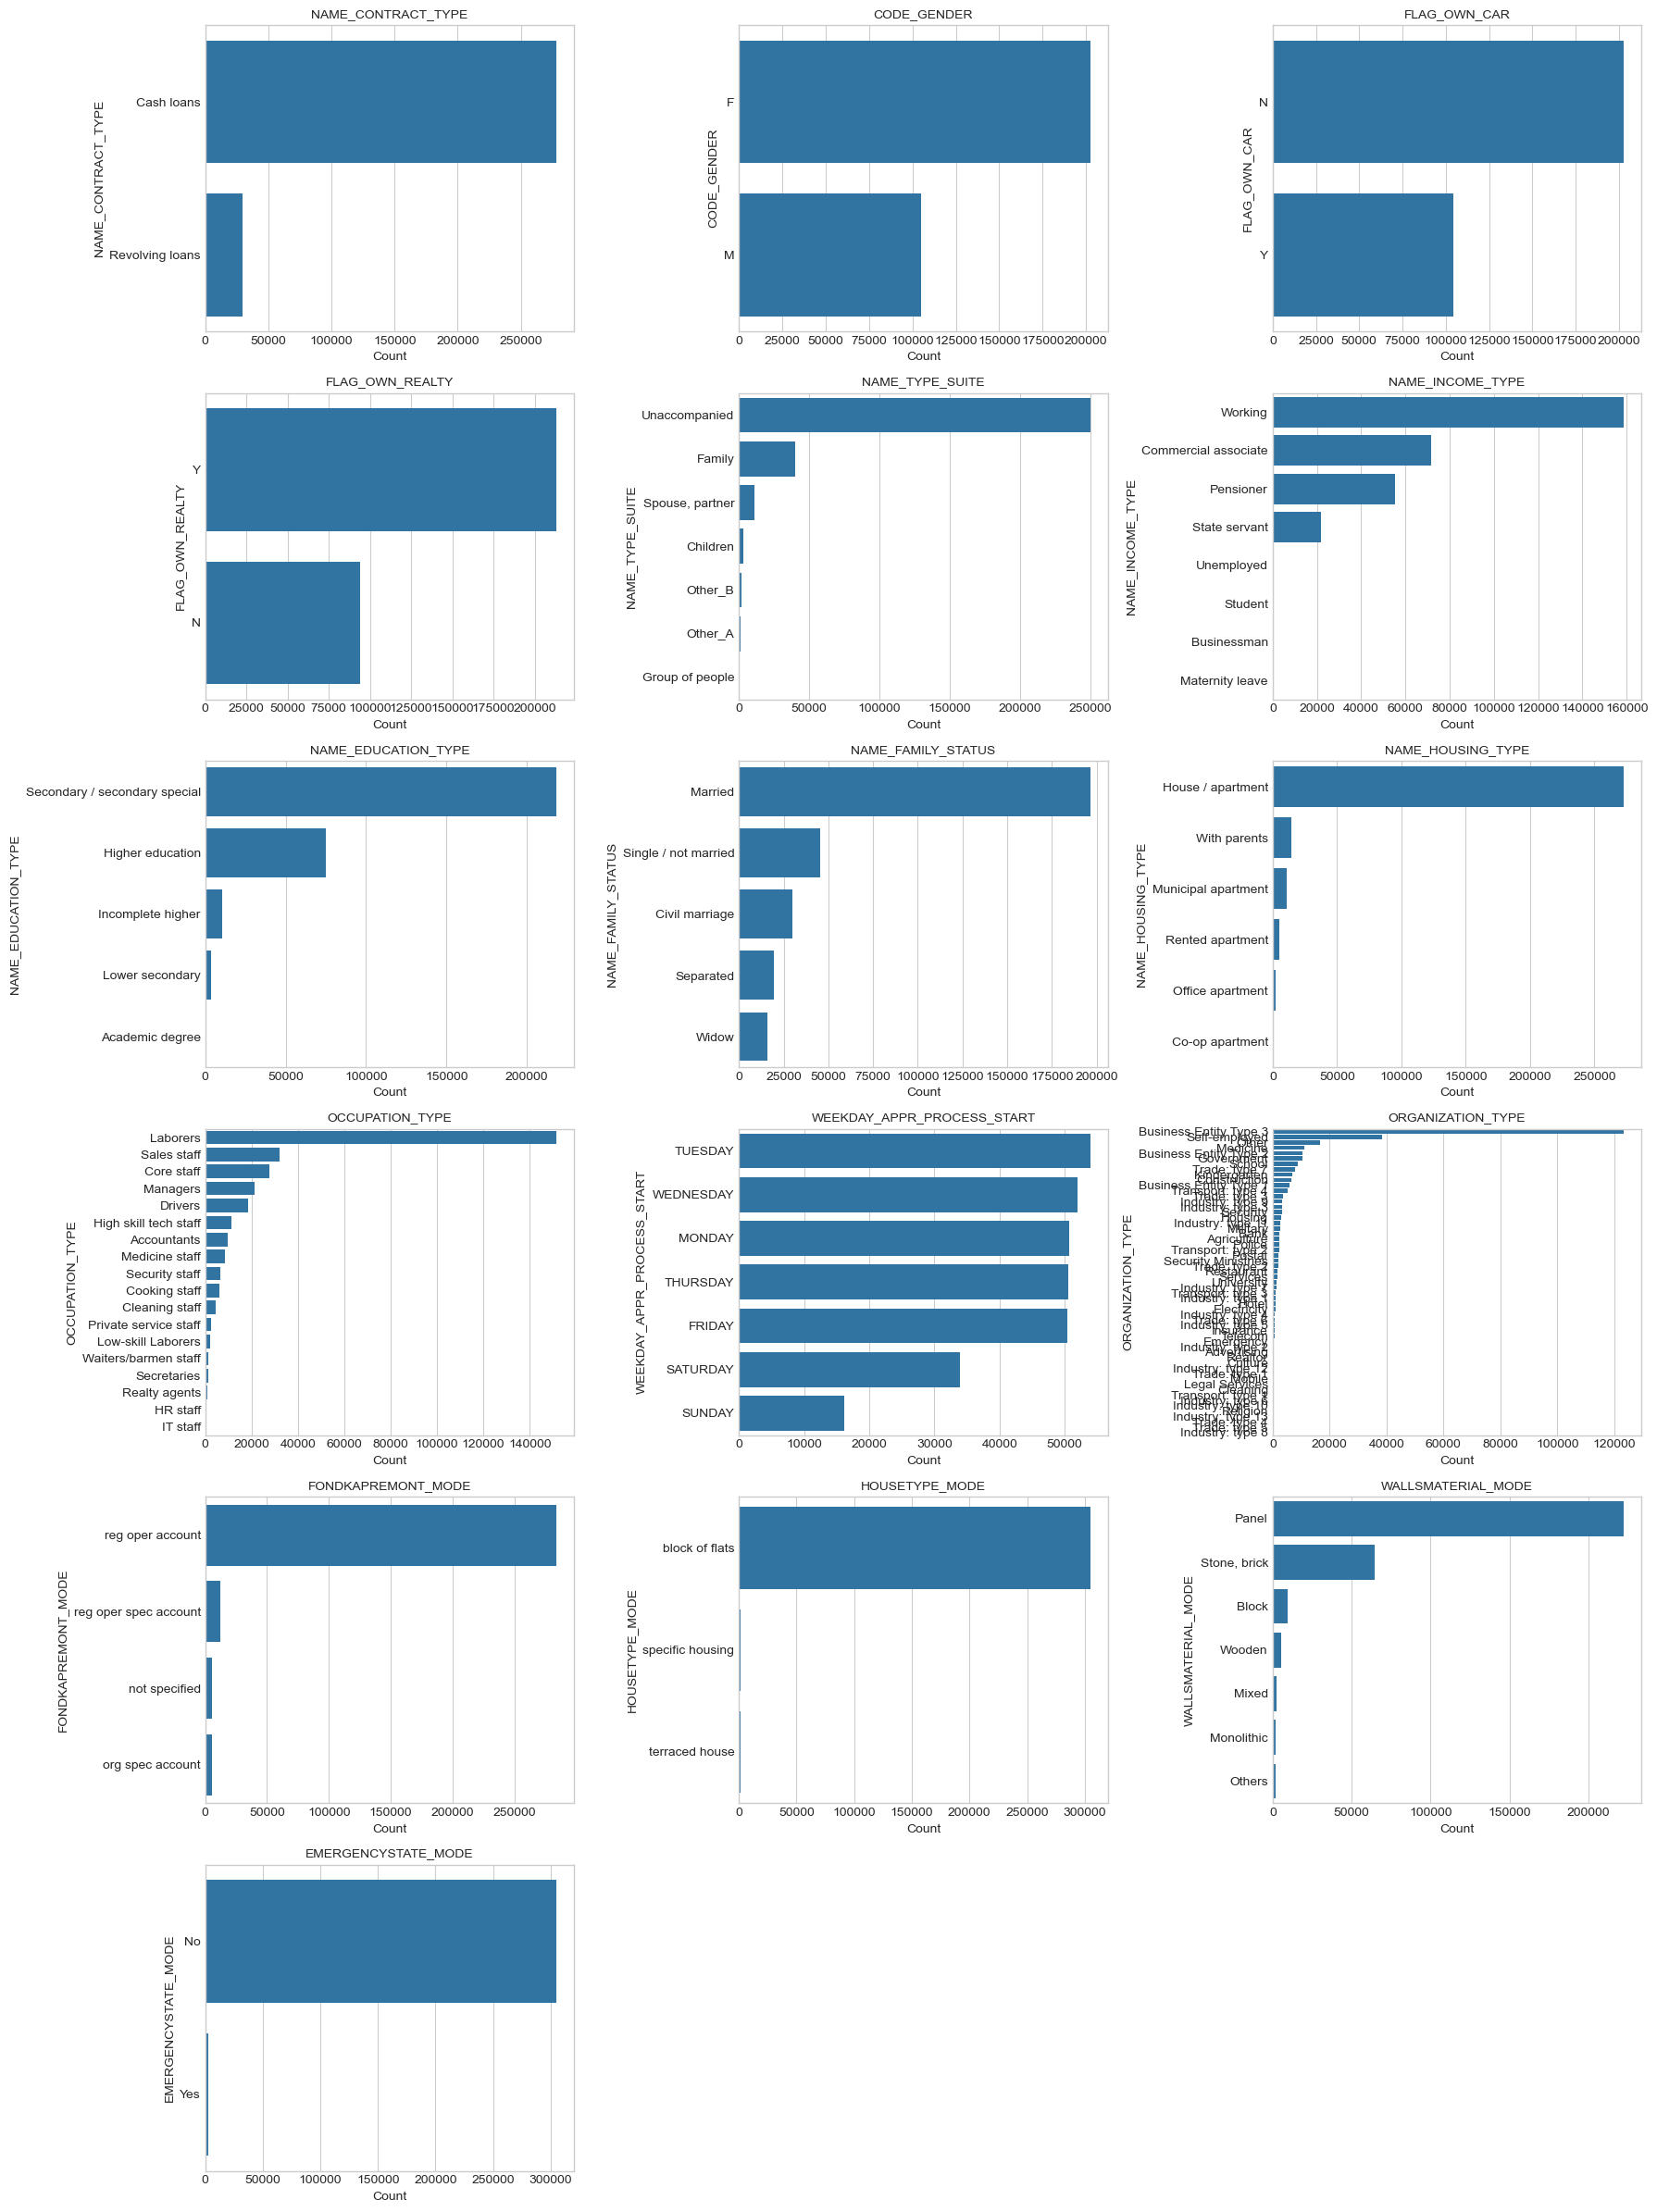

In [115]:
plot_categorical(app_train, categorical_cols)

## Key Findings from Univariate Analysis

### Numerical Feature Distributions

From the histogram and KDE plots, we observe:

**Financial Features**:
- **AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY** all exhibit **strong right skewness**, with long tails extending to high values
- Most applicants cluster in the lower ranges, suggesting the presence of outliers that were addressed in data cleaning
- **Implication for ML**: Log transformations will help normalize these distributions for linear models

**Temporal Features**:
- **DAYS_BIRTH** (age) shows a relatively normal distribution centered around middle age
- **DAYS_EMPLOYED** displays a concentration of values after removing the 365243 anomaly
- Most applicants have employment histories between 0-10 years

**External Credit Scores**:
- **EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3** show varying distributions
- EXT_SOURCE_2 and EXT_SOURCE_3 appear more populated (fewer missing values)
- Scores span the full [0, 1] range, indicating diverse credit profiles

### Categorical Feature Distributions

From the bar plots:

**Income Type**:
- **Working** class dominates the dataset 
- Significant representation of **Commercial associates** and **Pensioners**
- Small segments for **State servants** and **Maternity leave**
- **Implication for ML**: Income type segmentation important; consider grouping rare categories

**Contract Type**:
- **Cash loans** vastly outnumber **Revolving loans** (approximately 9:1 ratio)
- Class imbalance may require special handling during modeling
- **Implication for ML**: Different risk profiles likely between contract types

**Other Categorical Features**:
- Education type, occupation, and housing type show reasonable distributions
- No single category overwhelmingly dominates (good for modeling)

# 6. Bivariate Analysis (Two Variables)

## 6.1 Target vs Numerical Variables

In [116]:
def plot_numerical_vs_target(df, cols, target='TARGET', ncols=3):
    
    valid_cols = [col for col in cols if df[col].nunique() > 10]
    skipped = [col for col in cols if col not in valid_cols]
    
    if skipped:
        print(f"Skipped {len(skipped)} low-variance columns: {skipped[:5]}...")
    
    if not valid_cols:
        print("No valid columns to plot")
        return
    
    nrows = (len(valid_cols) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten() if len(valid_cols) > 1 else [axes]
    
    for i, col in enumerate(valid_cols):
        sns.kdeplot(data=df[df[target]==0], x=col, ax=axes[i], 
                   label='Non-Default (0)', fill=True, warn_singular=False)
        sns.kdeplot(data=df[df[target]==1], x=col, ax=axes[i], 
                   label='Default (1)', fill=True, warn_singular=False)
        axes[i].set_title(col, fontsize=10)
        axes[i].legend()
    
    for j in range(len(valid_cols), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [117]:
def plot_correlation_with_target(df, target='TARGET', top_n=30):
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlations = df[numeric_cols].corr()[target].drop(target).sort_values()
    
    top_corr = pd.concat([correlations.head(top_n//2), correlations.tail(top_n//2)])
    
    plt.figure(figsize=(10, 8))
    colors = ['green' if x > 0 else 'red' for x in top_corr.values]
    plt.barh(top_corr.index, top_corr.values, color=colors)
    plt.xlabel('Correlation with TARGET')
    plt.title(f'Top {top_n} Features Correlated with TARGET')
    plt.tight_layout()
    plt.show()
    
    return correlations

Skipped 56 low-variance columns: ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE']...


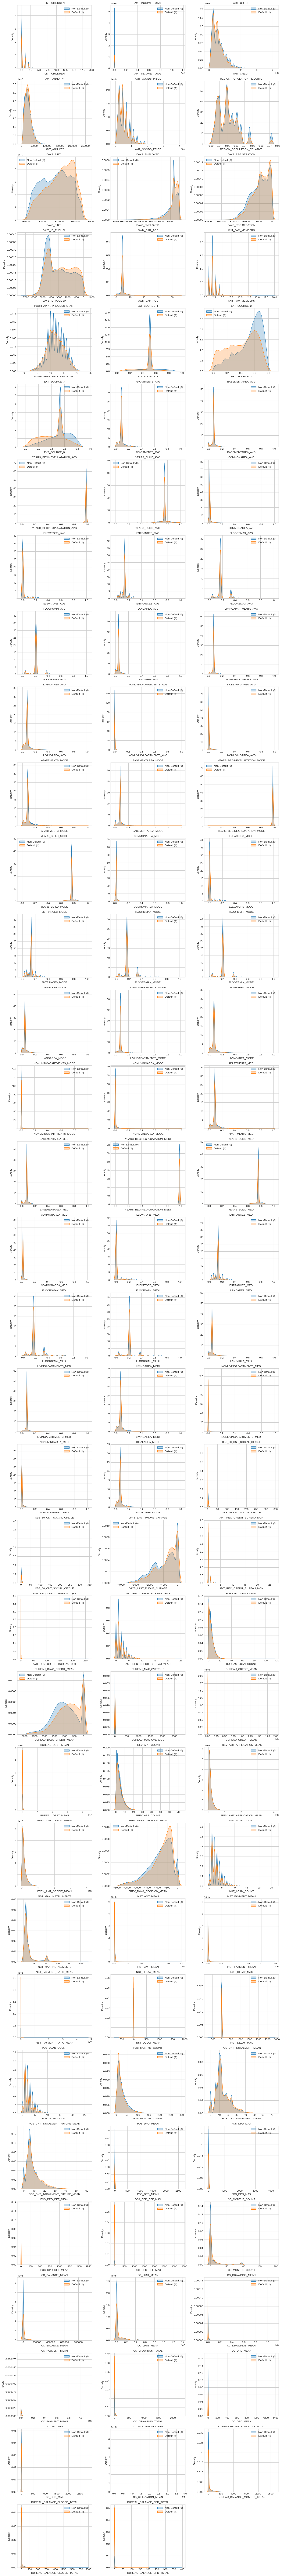

In [118]:
exclude = ['SK_ID_CURR', 'TARGET']
numeric_cols = [col for col in app_train.select_dtypes(include=[np.number]).columns if col not in exclude]
plot_numerical_vs_target(app_train, numeric_cols)

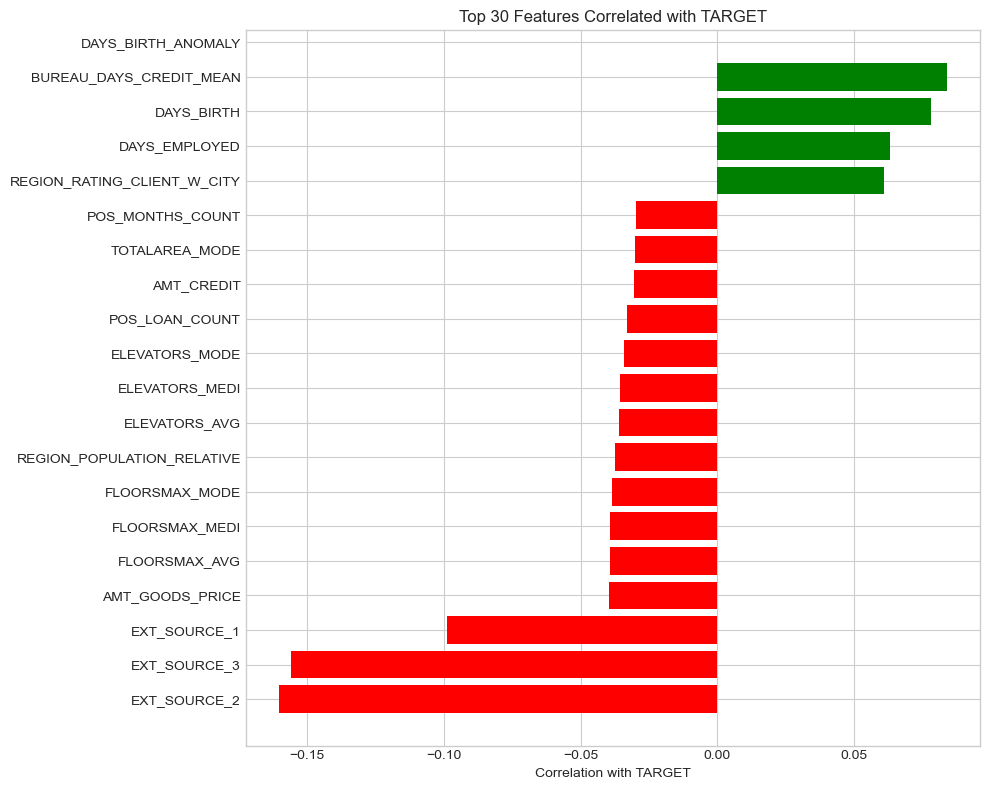

In [119]:
correlations = plot_correlation_with_target(app_train, top_n=30)

## 6.2 Target vs Categorical Variables

In [120]:
def plot_categorical_vs_target(df, cols, target='TARGET', ncols=2):
    
    nrows = (len(cols) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
    axes = axes.flatten() if len(cols) > 1 else [axes]
    
    for i, col in enumerate(cols):
        default_rate = df.groupby(col)[target].mean().sort_values(ascending=False)
        
        plot_df = pd.DataFrame({
            'category': default_rate.index,
            'default_rate': default_rate.values
        })
        
        sns.barplot(data=plot_df, x='default_rate', y='category', 
                   hue='category', ax=axes[i], palette='RdYlGn_r', legend=False)
        axes[i].set_title(f'{col} - Default Rate', fontsize=10)
        axes[i].set_xlabel('Default Rate')
        axes[i].set_ylabel('')
        
        for j, v in enumerate(default_rate.values):
            axes[i].text(v + 0.005, j, f'{v*100:.1f}%', va='center', fontsize=8)
    
    for j in range(len(cols), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

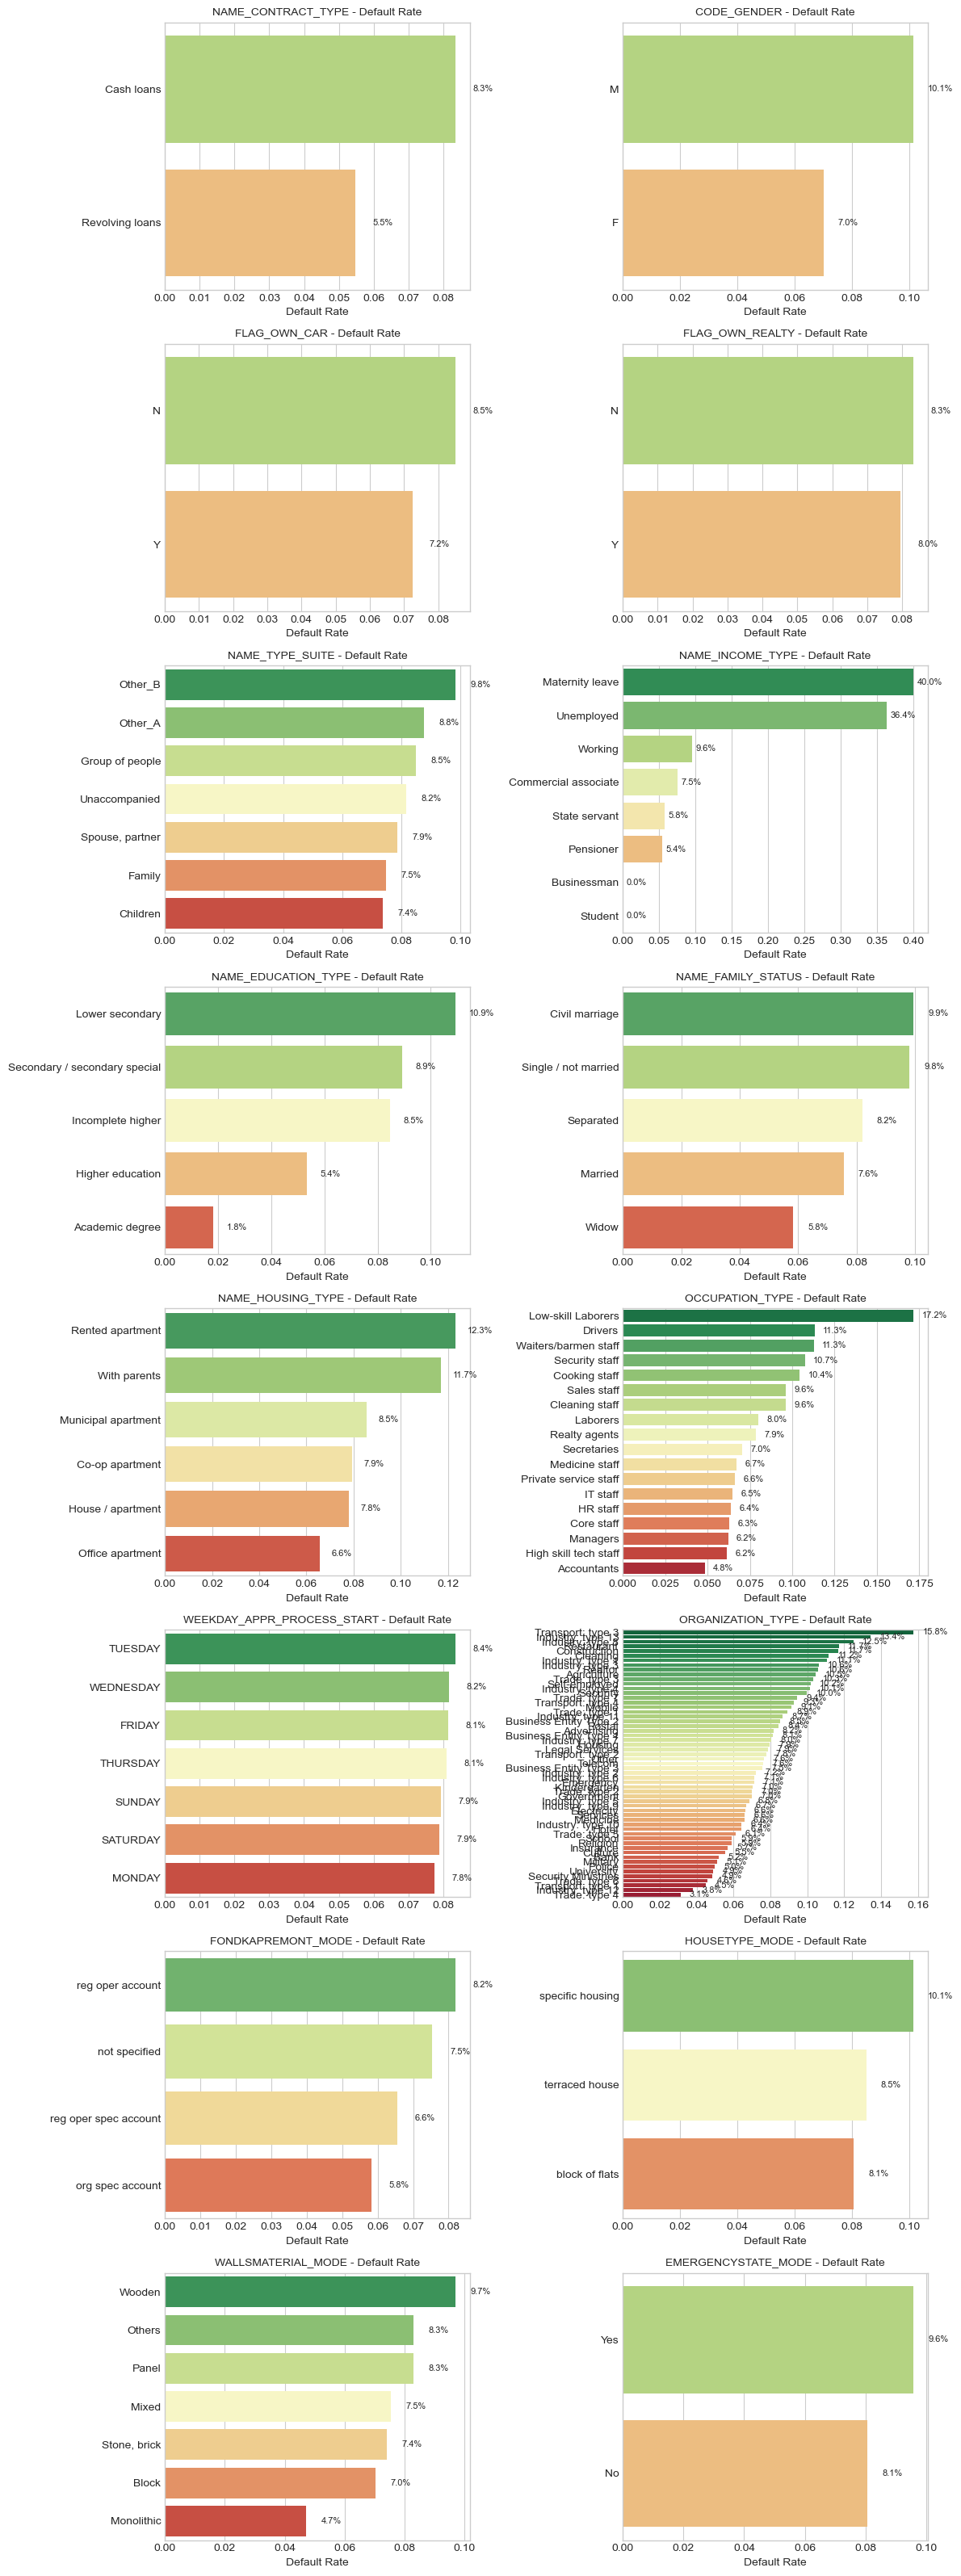

In [121]:
plot_categorical_vs_target(app_train, categorical_cols)

## Key Findings from Bivariate Analysis

### Numerical Features vs. Default Risk (TARGET)

From the **KDE plots comparing defaulters (orange) vs. non-defaulters (blue)**:

**External Credit Scores - Strongest Discriminators**:
- **EXT_SOURCE_2 and EXT_SOURCE_3** show **clear separation** between the two distributions
- Defaulters concentrate at **lower score ranges** (left side of distribution)
- Non-defaulters skew toward **higher score ranges** (right side)
- **Key Insight**: External credit scores are highly predictive - defaulters consistently score lower

**Age (DAYS_BIRTH)**:
- Distributions show **some separation**, with younger applicants (larger negative values = younger) appearing more in the defaulter group
- Non-defaulters have a slightly older distribution on average
- **Key Insight**: Age is a moderate predictor - younger applicants present higher risk

**Financial Features**:
- **AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY** show **largely overlapping distributions**
- Minimal visual separation between defaulters and non-defaulters
- **Key Insight**: Raw financial amounts alone are weak predictors - ratios and interactions likely more informative (confirmed by our feature engineering)

**Employment Duration**:
- Some overlap observed, but defaulters show tendency toward shorter employment
- **Key Insight**: Employment stability matters but not as strongly as credit scores

### Feature Correlation with TARGET

From the **correlation bar chart**:

**Strongest Negative Correlations** (lower values = higher default risk):
- **EXT_SOURCE_3, EXT_SOURCE_2, EXT_SOURCE_1** dominate the top positions
- These three features show the **strongest predictive power** in the entire dataset
- Correlation magnitudes are moderate, indicating real but non-linear relationships

**Other Notable Correlations**:
- **DAYS_BIRTH** shows positive correlation (younger = higher risk)
- **DAYS_EMPLOYED** shows negative correlation (longer employment = lower risk)
- Various aggregated features from supplementary tables (bureau, previous applications) appear in top 30

**Weak or No Correlation**:
- Many FLAG_DOCUMENT features show minimal correlation
- Several AMT_ features show weak direct correlation
- **Key Insight**: Confirms that raw amounts less predictive than ratios and external validations

### Categorical Features vs. Default Risk

From the **default rate bar plots (sorted by rate)**:

**Contract Type**:
- Observable differences in default rates between **Cash loans** and **Revolving loans**
- One type shows notably higher default rate than the other
- **Implication**: Contract type should be included as a feature

**Income Type**:
- Clear risk segmentation visible across income types
- Certain income types show higher default rates than others
- **Working** class and **Commercial associates** show moderate, stable rates
- Different income sources demonstrate varying risk profiles
- **Implication**: Strong candidate for risk-based segmentation in modeling

**Education and Occupation**:
- Default rates vary across categories
- Some occupations/education levels present lower risk than others
- **Implication**: Include these features but watch for rare categories during train/test split

### How Bivariate EDA Informed ML Direction:

**1. Feature Prioritization**:
- EXT_SOURCE features confirmed as **must-have** predictors for both models
- Age and employment duration as **secondary** predictors

**2. Feature Engineering Validation**:
- Weak direct correlations of AMT_ features justify our ratio-based features (CREDIT_INCOME_RATIO, etc.)
    
**3. Model Selection Rationale**:
- **LightGBM**: The non-linear separation patterns (especially in EXT_SOURCE KDE plots) and overlapping distributions suggest tree-based models will capture complex relationships better than linear approaches
- **Logistic Regression**: Serves as interpretable baseline; moderate correlations (~0.15-0.18) indicate potential for linear model with proper feature engineering and regularization

**4. Risk Segmentation Opportunities**:
- Income type and contract type show distinct risk profiles

# 7. Multivariate Analysis

In [122]:
def plot_correlation_heatmap(df, cols=None, figsize=(12, 10)):

    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
        cols = [c for c in cols if c not in ['SK_ID_CURR', 'TARGET']]
    
    valid_cols = [c for c in cols if df[c].std() > 0 and df[c].nunique() > 1]
    
    if len(valid_cols) > 30:
        if 'TARGET' in df.columns:
            corr_with_target = df[valid_cols].corrwith(df['TARGET']).abs().sort_values(ascending=False)
            valid_cols = corr_with_target.head(30).index.tolist()
        else:
            valid_cols = valid_cols[:30]
    
    corr_matrix = df[valid_cols].corr()
    
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=False, cmap='RdBu_r', center=0,
                square=True, linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

In [123]:
def find_high_correlations(df, threshold=0.7):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [c for c in numeric_cols if c not in ['SK_ID_CURR', 'TARGET']]
    
    valid_cols = [c for c in numeric_cols if df[c].std() > 0 and df[c].nunique() > 1]
    
    corr_matrix = df[valid_cols].corr().abs()
    
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    high_corr_pairs = []
    for col in upper.columns:
        for idx in upper.index:
            val = upper.loc[idx, col]
            if pd.notna(val) and val > threshold:
                high_corr_pairs.append({
                    'feature_1': idx,
                    'feature_2': col,
                    'correlation': val
                })
    
    result = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False)
    
    print(f"Found {len(result)} feature pairs with correlation > {threshold}")
    print(result.head(20))
    
    return result

In [124]:
def plot_pairplot(df, cols, target='TARGET'):

    if len(cols) > 5:
        print("Warning: Too many columns, using first 5")
        cols = cols[:5]
    
    plot_cols = cols + [target] if target in df.columns else cols
    
    sns.pairplot(df[plot_cols], hue=target, palette='Set1', 
                 diag_kind='kde', corner=True)
    plt.tight_layout()
    plt.show()

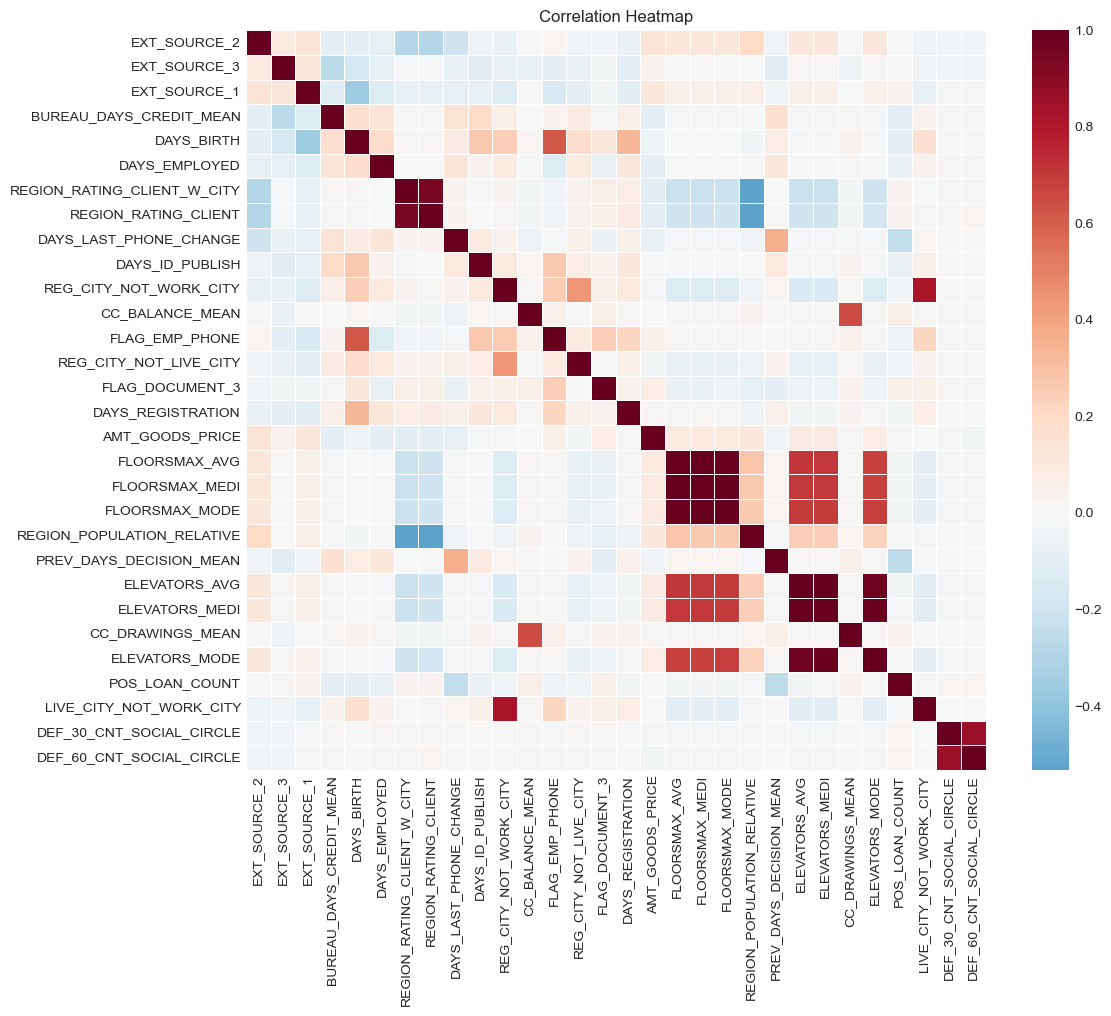

In [125]:
corr_matrix = plot_correlation_heatmap(app_train)

In [126]:
high_corr = find_high_correlations(app_train, threshold=0.7)

Found 126 feature pairs with correlation > 0.7
                       feature_1                       feature_2  correlation
111                   FLAG_MOBIL  DAYS_LAST_PHONE_CHANGE_MISSING     1.000000
110   NAME_FAMILY_STATUS_MISSING         CNT_FAM_MEMBERS_MISSING     1.000000
53               YEARS_BUILD_AVG                YEARS_BUILD_MEDI     0.998495
108     OBS_30_CNT_SOCIAL_CIRCLE        OBS_60_CNT_SOCIAL_CIRCLE     0.998491
71                 FLOORSMIN_AVG                  FLOORSMIN_MEDI     0.997278
68                 FLOORSMAX_AVG                  FLOORSMAX_MEDI     0.997260
65                 ENTRANCES_AVG                  ENTRANCES_MEDI     0.996900
58                 ELEVATORS_AVG                  ELEVATORS_MEDI     0.996692
55                COMMONAREA_AVG                 COMMONAREA_MEDI     0.996229
85                LIVINGAREA_AVG                 LIVINGAREA_MEDI     0.995783
41                APARTMENTS_AVG                 APARTMENTS_MEDI     0.995234
49              B

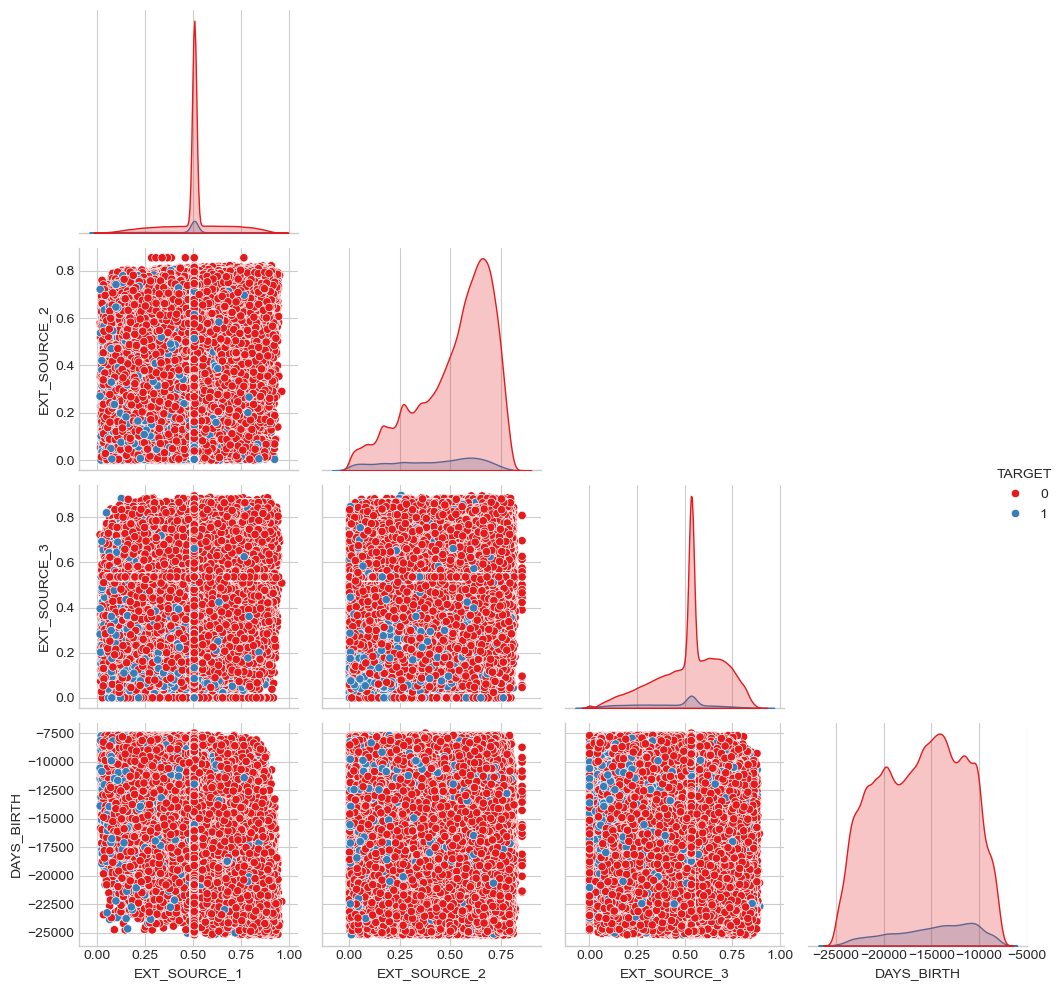

In [127]:
key_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']
plot_pairplot(app_train, key_features)

## Key Findings from Multivariate Analysis

### Correlation Heatmap Analysis

From the **full feature correlation matrix**:

**High Correlation Clusters Identified**:
- **Regional features** (REGION_RATING_CLIENT, REGION_POPULATION_RELATIVE, etc.) show **strong inter-correlation** (>0.8)
  - **Implication**: Feature redundancy detected - select representative features or apply regularization
  
- **Document flags** (FLAG_DOCUMENT_*) show low variance and minimal correlation with other features
  - Many appear as near-zero correlation throughout the heatmap
  - **Implication**: Consider removing low-information document flags for Logistic Regression

**EXT_SOURCE Inter-Correlations**:
- EXT_SOURCE_1, 2, and 3 show **moderate positive correlation** (~0.3-0.5 range) with each other
- Not perfectly correlated, indicating each provides **unique information**
- **Implication**: Keep all three EXT_SOURCE features despite correlation

**Financial Feature Correlations**:
- AMT_CREDIT, AMT_GOODS_PRICE, and AMT_ANNUITY show expected **strong positive correlations**
- Confirms these features are related but our ratio features (CREDIT_GOODS_RATIO, etc.) capture the relationships more effectively

### Pairplot Analysis (Key Features)

From the **pairplot of [EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, DAYS_BIRTH] with TARGET as hue**:

**EXT_SOURCE Relationships**:
- Scatter plots reveal **moderate positive relationships** between external scores
- **Color separation visible**: Orange (defaulters) concentrate in **lower-score regions**, blue (non-defaulters) spread more evenly
- **Non-linear patterns observed**: Not simple straight-line relationships
- **Key Insight**: Interaction terms between EXT_SOURCE features may capture additional predictive power

**Age (DAYS_BIRTH) Interactions**:
- EXT_SOURCE × Age scatter plots show **some clustering patterns**
- Younger applicants with low external scores form a **high-risk cluster** (more orange points)
- Older applicants with high external scores form a **low-risk cluster** (more blue points)
- **Key Insight**: Age-score interaction features valuable (supports our EMPLOYED_AGE_RATIO feature)

**Distribution Diagonals**:
- Histograms along diagonal confirm:
  - EXT_SOURCE features show bimodal or uniform distributions
  - DAYS_BIRTH (age) relatively normal
  - Clear color separation in EXT_SOURCE histograms (orange skews left, blue more distributed)

### Multicollinearity and Feature Selection Insights

**Identified Redundancies**:
- Multiple regional features capture similar information
- Several FLAG_ features provide minimal unique value
- Some aggregated features from supplementary tables overlap

**Recommendations for Modeling**:

- **LightGBM**: Not significantly affected by multicollinearity due to tree-based nature
- **Logistic Regression**: Use **L2 regularization (Ridge)** to handle correlated features

# 8. Outlier Detection

## 8.1 Detect Outlier

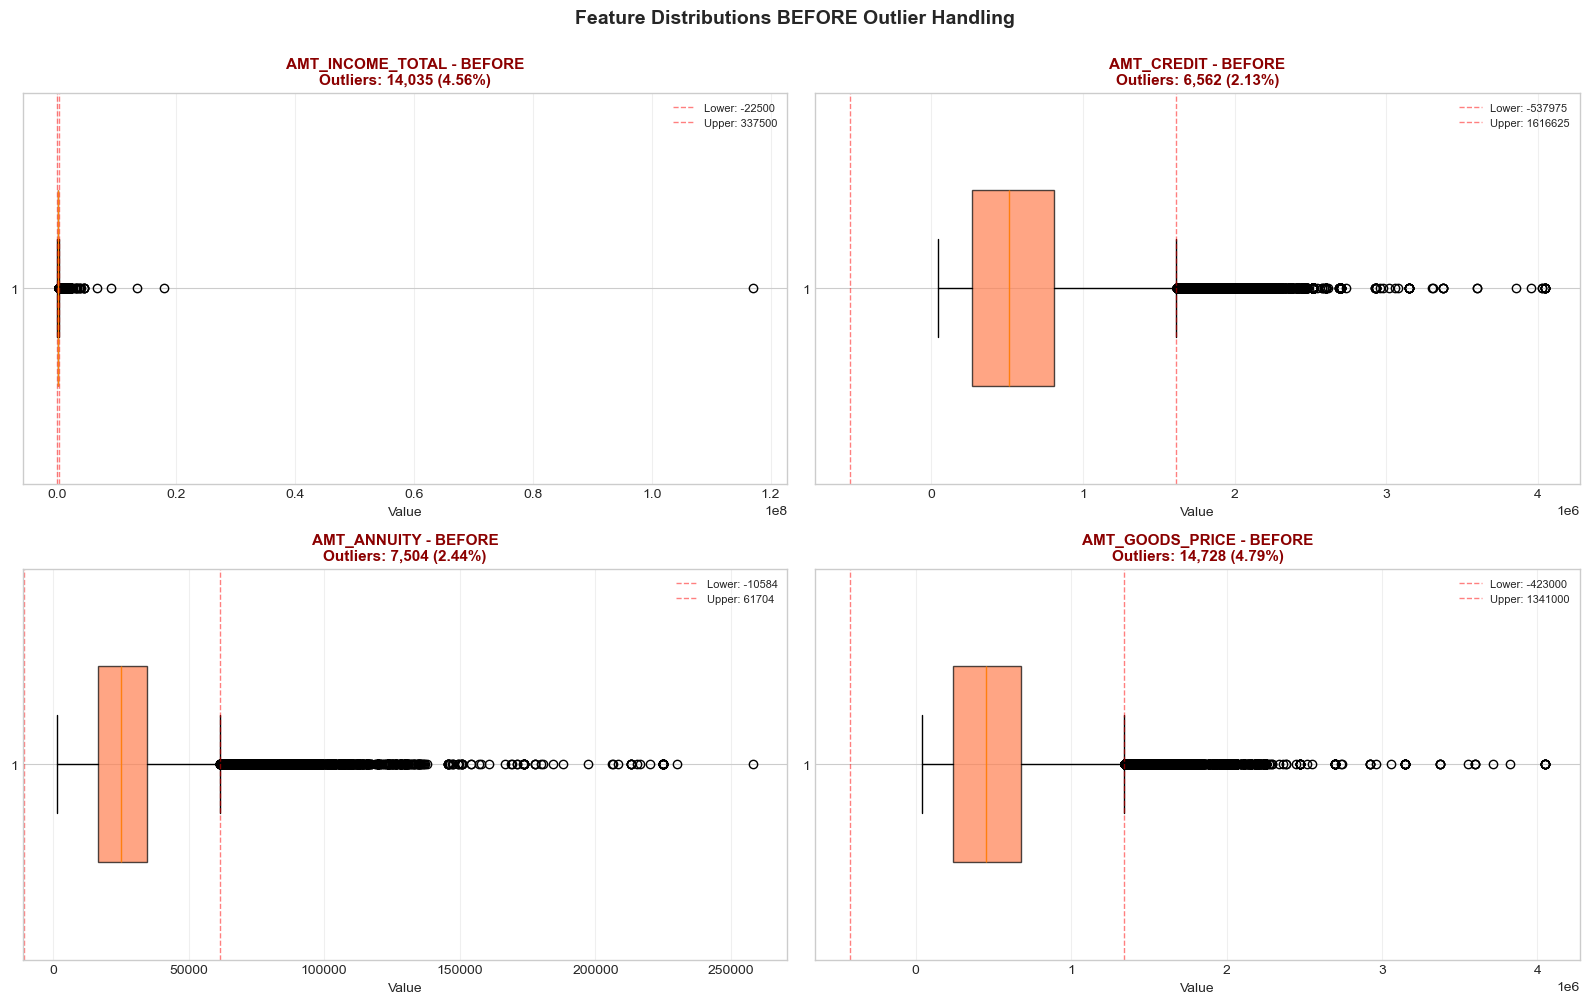

In [128]:
# Save key features BEFORE outlier handling for comparison
key_features_for_outlier_viz = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
app_train_before_outlier = app_train[key_features_for_outlier_viz].copy()

# Visualize distributions BEFORE outlier handling
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(key_features_for_outlier_viz):
    ax = axes[idx]
    
    # Box plot
    bp = ax.boxplot(app_train[col].dropna(), vert=False, widths=0.5, patch_artist=True)
    bp['boxes'][0].set_facecolor('coral')
    bp['boxes'][0].set_alpha(0.7)
    
    # Statistics
    Q1 = app_train[col].quantile(0.25)
    Q3 = app_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((app_train[col] < lower_bound) | (app_train[col] > upper_bound)).sum()
    outlier_pct = (outliers / len(app_train)) * 100
    
    ax.set_xlabel('Value', fontsize=10)
    ax.set_title(f'{col} - BEFORE\nOutliers: {outliers:,} ({outlier_pct:.2f}%)', 
                 fontsize=11, fontweight='bold', color='darkred')
    ax.grid(axis='x', alpha=0.3)
    
    # Add reference lines
    ax.axvline(lower_bound, color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Lower: {lower_bound:.0f}')
    ax.axvline(upper_bound, color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Upper: {upper_bound:.0f}')
    ax.legend(fontsize=8)

plt.suptitle('Feature Distributions BEFORE Outlier Handling', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [129]:
def detect_outliers_iqr(df, cols=None, k=1.5):
 
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
        cols = [c for c in cols if c not in ['SK_ID_CURR', 'TARGET']]
    
    outlier_summary = []
    
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower = Q1 - k * IQR
        upper = Q3 + k * IQR
        
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outlier_count = len(outliers)
        outlier_pct = outlier_count / len(df) * 100
        
        if outlier_count > 0:
            outlier_summary.append({
                'column': col,
                'outlier_count': outlier_count,
                'outlier_pct': round(outlier_pct, 2),
                'lower_bound': round(lower, 2),
                'upper_bound': round(upper, 2),
                'min': round(df[col].min(), 2),
                'max': round(df[col].max(), 2)
            })
    
    result = pd.DataFrame(outlier_summary).sort_values('outlier_pct', ascending=False)
    print(f"Found outliers in {len(result)} columns")
    return result

In [130]:
iqr_outliers = detect_outliers_iqr(app_train)

Found outliers in 141 columns


In [131]:
def detect_outliers_zscore(df, cols=None, threshold=3):
    
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
        cols = [c for c in cols if c not in ['SK_ID_CURR', 'TARGET'] and df[c].std() > 0]
    
    outlier_summary = []
    
    for col in cols:
        mean = df[col].mean()
        std = df[col].std()
        
        if std == 0:
            continue
        
        z_scores = np.abs((df[col] - mean) / std)
        outlier_count = (z_scores > threshold).sum()
        outlier_pct = outlier_count / len(df) * 100
        
        if outlier_count > 0:
            outlier_summary.append({
                'column': col,
                'outlier_count': outlier_count,
                'outlier_pct': round(outlier_pct, 2),
                'mean': round(mean, 2),
                'std': round(std, 2),
                'max_zscore': round(z_scores.max(), 2)
            })
    
    result = pd.DataFrame(outlier_summary).sort_values('outlier_pct', ascending=False)
    print(f"Found outliers in {len(result)} columns (z-score > {threshold})")
    return result

In [132]:
zscore_outliers = detect_outliers_zscore(app_train)

Found outliers in 134 columns (z-score > 3)


In [133]:
def plot_outliers_boxplot(df, cols, ncols=4):

    nrows = (len(cols) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
    axes = axes.flatten()
    
    for i, col in enumerate(cols):
        sns.boxplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(col, fontsize=9)
    
    for j in range(len(cols), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

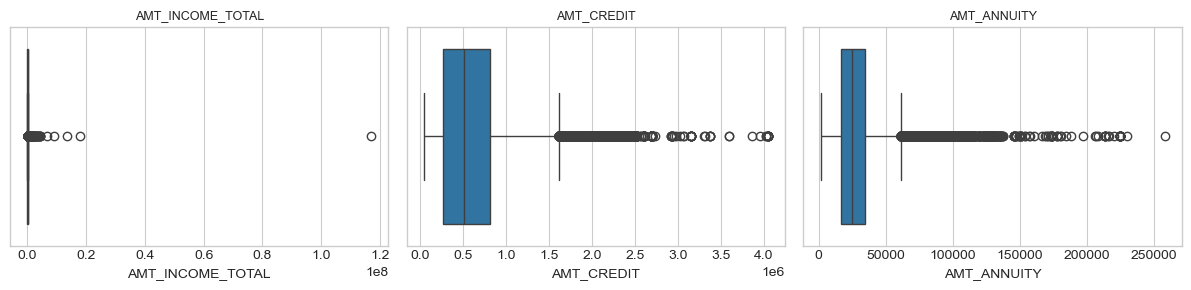

In [134]:
plot_outliers_boxplot(app_train, ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY'])

## 8.2 Handle Outliers

In [135]:
def handle_outliers(df, k=1.5):
    df = df.copy()
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c not in ['SK_ID_CURR', 'TARGET']]
    
    outlier_bounds = {}
    
    for col in numeric_cols:
        if col.startswith('FLAG_') or df[col].nunique() <= 2:
            continue
        
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR
        
        if col.startswith('DAYS_'):
            upper_bound = min(upper_bound, 0)
            lower_bound = max(lower_bound, -30000)
        
        elif col.startswith('AMT_'):
            lower_bound = max(lower_bound, 0)
        
        elif col.startswith('CNT_'):
            lower_bound = max(lower_bound, 0)
        
        elif 'EXT_SOURCE' in col:
            lower_bound = max(lower_bound, 0)
            upper_bound = min(upper_bound, 1)
        
        outlier_bounds[col] = {'lower': lower_bound, 'upper': upper_bound}
        
        original_dtype = df[col].dtype
        
        if 'int' in str(original_dtype).lower() or 'Int' in str(original_dtype):
            df[col] = df[col].astype('float64').clip(lower=lower_bound, upper=upper_bound).round().astype(original_dtype)
        else:
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    
    print(f"Processed {len(outlier_bounds)} columns with business logic constraints")
    
    return df

app_train = handle_outliers(app_train, k=1.5)
app_test = handle_outliers(app_test, k=1.5)

Processed 109 columns with business logic constraints
Processed 109 columns with business logic constraints


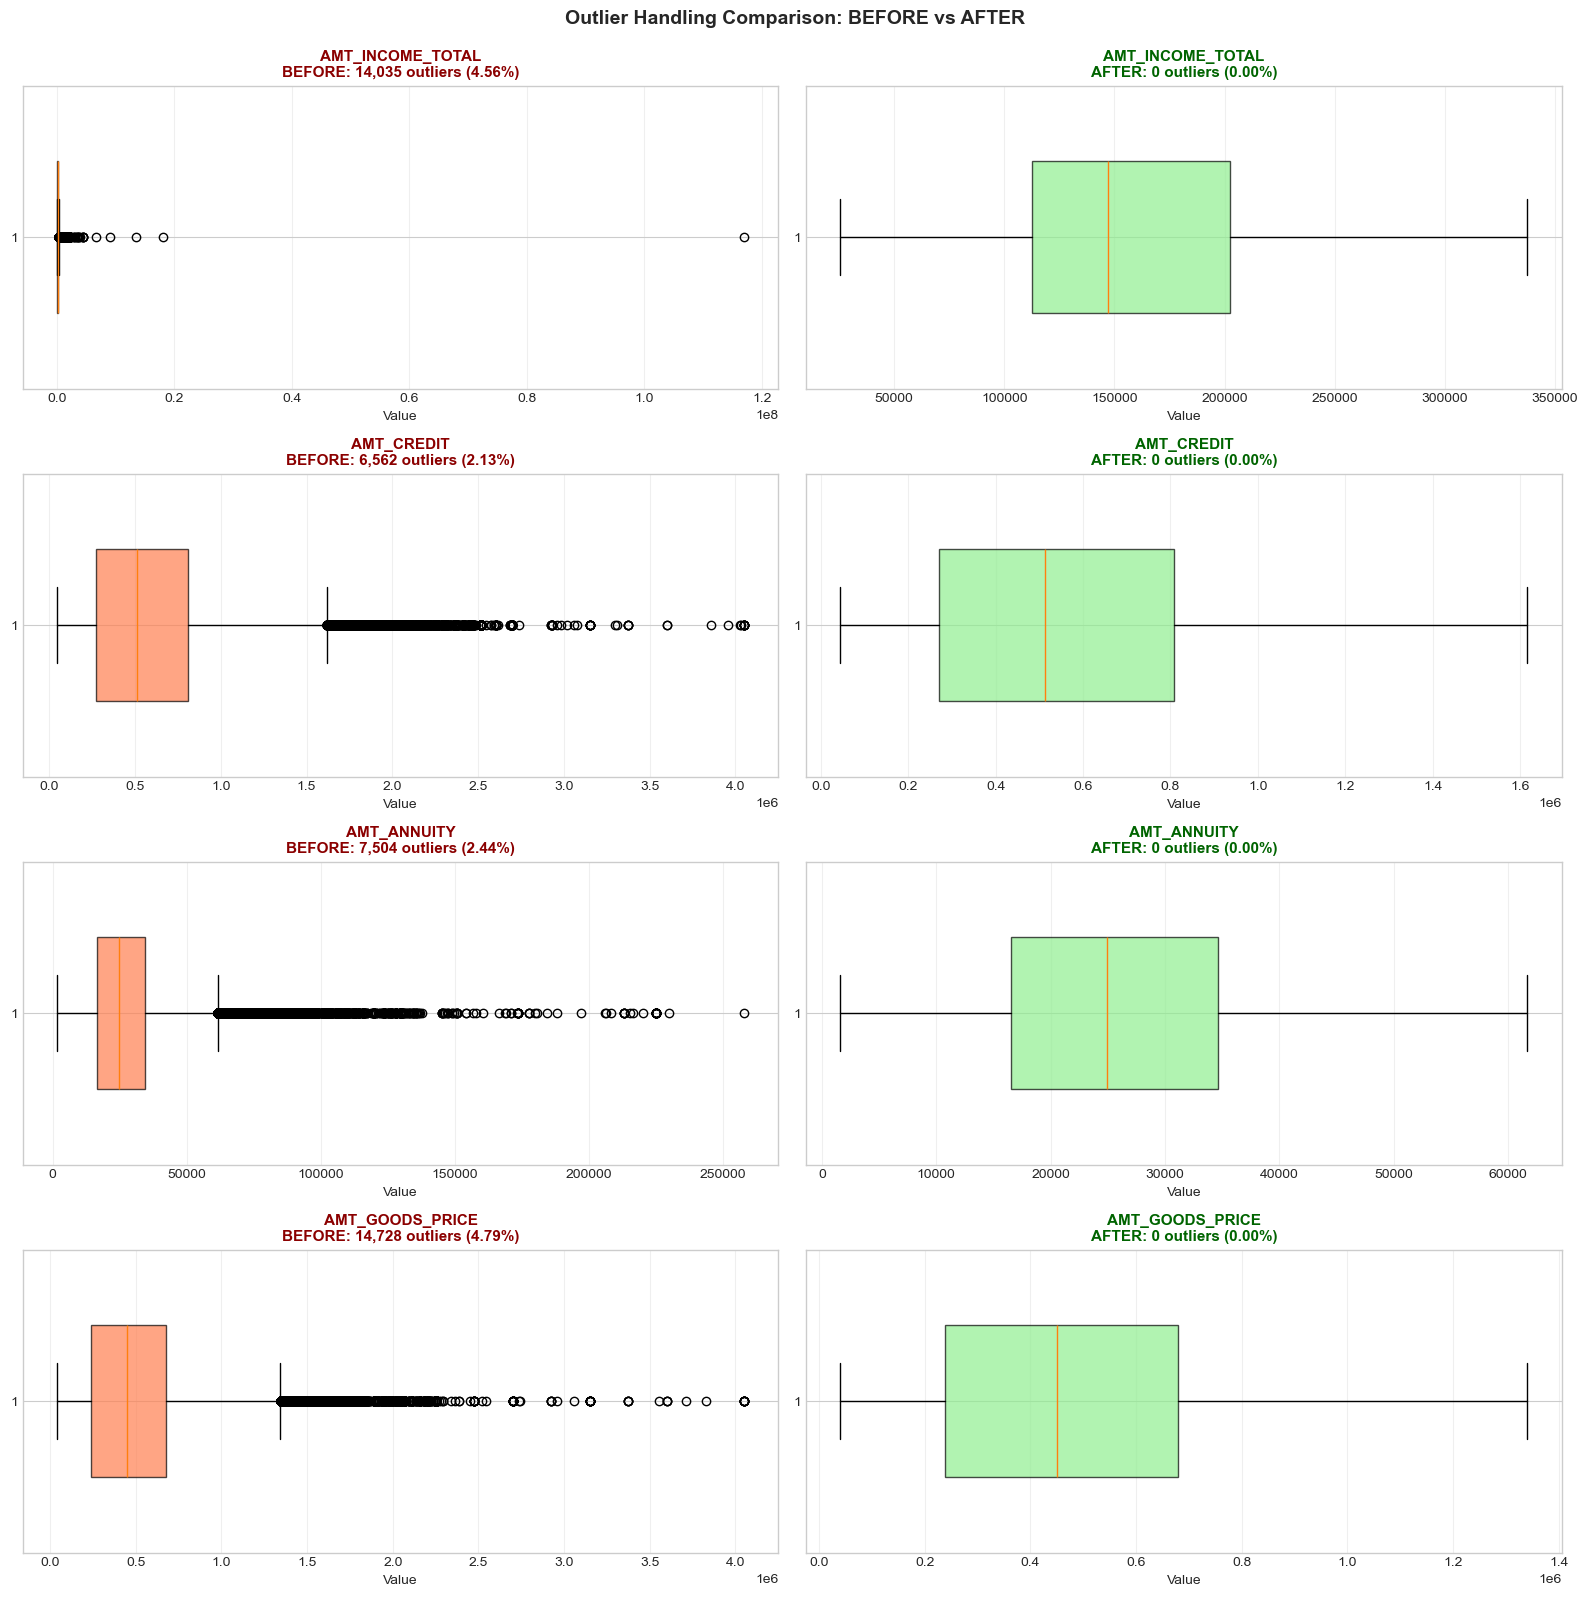

In [136]:
# Compare BEFORE vs AFTER outlier handling
fig, axes = plt.subplots(4, 2, figsize=(16, 16))

for idx, col in enumerate(key_features_for_outlier_viz):
    # Before (left column)
    ax_before = axes[idx, 0]
    bp_before = ax_before.boxplot(app_train_before_outlier[col].dropna(), vert=False, widths=0.5, patch_artist=True)
    bp_before['boxes'][0].set_facecolor('coral')
    bp_before['boxes'][0].set_alpha(0.7)
    
    Q1_before = app_train_before_outlier[col].quantile(0.25)
    Q3_before = app_train_before_outlier[col].quantile(0.75)
    IQR_before = Q3_before - Q1_before
    outliers_before = ((app_train_before_outlier[col] < Q1_before - 1.5*IQR_before) | 
                       (app_train_before_outlier[col] > Q3_before + 1.5*IQR_before)).sum()
    
    ax_before.set_xlabel('Value', fontsize=10)
    ax_before.set_title(f'{col}\nBEFORE: {outliers_before:,} outliers ({outliers_before/len(app_train)*100:.2f}%)', 
                        fontsize=11, fontweight='bold', color='darkred')
    ax_before.grid(axis='x', alpha=0.3)
    
    # After (right column)
    ax_after = axes[idx, 1]
    bp_after = ax_after.boxplot(app_train[col].dropna(), vert=False, widths=0.5, patch_artist=True)
    bp_after['boxes'][0].set_facecolor('lightgreen')
    bp_after['boxes'][0].set_alpha(0.7)
    
    Q1_after = app_train[col].quantile(0.25)
    Q3_after = app_train[col].quantile(0.75)
    IQR_after = Q3_after - Q1_after
    outliers_after = ((app_train[col] < Q1_after - 1.5*IQR_after) | 
                      (app_train[col] > Q3_after + 1.5*IQR_after)).sum()
    
    ax_after.set_xlabel('Value', fontsize=10)
    ax_after.set_title(f'{col}\nAFTER: {outliers_after:,} outliers ({outliers_after/len(app_train)*100:.2f}%)', 
                       fontsize=11, fontweight='bold', color='darkgreen')
    ax_after.grid(axis='x', alpha=0.3)

plt.suptitle('Outlier Handling Comparison: BEFORE vs AFTER', fontsize=14, fontweight='bold', y=0.995)
plt.savefig('outlier.png')
plt.tight_layout()
plt.show()

# 9. Feature Engineering

In [137]:
def feature_engineering(df):
    df = df.copy()
    
    # 1. Ratio features
    df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1)
    df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + 1)
    df['CREDIT_ANNUITY_RATIO'] = df['AMT_CREDIT'] / (df['AMT_ANNUITY'] + 1)
    df['GOODS_CREDIT_RATIO'] = df['AMT_GOODS_PRICE'] / (df['AMT_CREDIT'] + 1)
    
    # 2. Time features
    df['AGE_YEARS'] = -df['DAYS_BIRTH'] / 365
    df['EMPLOYED_YEARS'] = -df['DAYS_EMPLOYED'] / 365
    df['EMPLOYED_AGE_RATIO'] = df['EMPLOYED_YEARS'] / (df['AGE_YEARS'] + 1)
    
    # 3. EXT_SOURCE
    df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['EXT_SOURCE_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    
    # 4. Income/family
    df['INCOME_PER_FAMILY'] = df['AMT_INCOME_TOTAL'] / (df['CNT_FAM_MEMBERS'] + 1)
    df['INCOME_PER_CHILD'] = df['AMT_INCOME_TOTAL'] / (df['CNT_CHILDREN'] + 1)
    
    # 5. Log transformation（for skewness）
    skewed_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
    for col in skewed_cols:
        if col in df.columns:
            df[f'{col}_LOG'] = np.log1p(df[col])
    
    print(f"Created {df.shape[1]} features (original + new)")
    
    return df

app_train = feature_engineering(app_train)
app_test = feature_engineering(app_test)

Created 190 features (original + new)
Created 189 features (original + new)


In [138]:
app_train.to_csv('./Dataset/application_train_cleaned.csv', index=False)
app_test.to_csv('./Dataset/application_test_cleaned.csv', index=False)